In [68]:
# -*- coding: utf-8 -*-

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import time
import math
import random
import pandas as pd
import scipy.signal
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as dist
from trajectory_dataPrepare8 import *

torch.manual_seed(0)

MAX_LENGTH = 100
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('ok')
length = 100
predict_length=30
Training_generator, Test, Valid, WholeSet= get_dataloader(128,length,predict_length)
print(len(WholeSet))
class NNPred(nn.Module):
    def __init__(self, input_size, output_size,hidden_size,batch_size, dropout=0.5):
        super(NNPred, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.in2lstm = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,num_layers=self.num_layers,bidirectional=False,batch_first=True,dropout =dropout)
        self.in2bilstm = nn.Linear(input_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2,num_layers=self.num_layers,bidirectional=True,batch_first=True,dropout =dropout)
    
        self.fc0 = nn.Linear(hidden_size,hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2,int(hidden_size/2))
        self.in2out = nn.Linear(input_size, int(hidden_size/2))
        self.fc2 = nn.Linear(int(hidden_size/2) ,output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        #input = tensor shape[batchsize, len, num_features]
        bilstm_out,_= self.bilstm(self.in2bilstm(input))
        lstm_out,_= self.lstm(self.in2lstm(input))
        out = self.tanh(self.fc0(lstm_out+bilstm_out))
        out = self.tanh(self.fc1(out))
        out =  out + self.in2out(input)
        output = self.fc2(out)# range [0 -> 1 ]
        return output


ok
****************************** ——-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-————-—— ******************************
---轨迹输入数据结构： torch.Size([128, 100, 26]) ---轨迹输出数据结构： torch.Size([128, 100, 4]) --行为输入数据结构
---轨迹长度： 100 ---预测轨迹长度： 30
17320


In [69]:
import  torch
import numpy as np
f = [[[2,3],[4,5],[4,6]]]
d = [[[1,1,1]]]
print(np.array(f).shape,np.array(d).shape)
g = torch.tensor(d).bmm(torch.tensor(f))
h = torch.tensor([[[1,1]]])
print(g)
print(h+g)

(1, 3, 2) (1, 1, 3)
tensor([[[10, 14]]])
tensor([[[11, 15]]])


In [70]:
a = np.array([[[1,2],[2,3]]])
print(a.shape,a*a)

(1, 2, 2) [[[1 4]
  [4 9]]]


In [71]:
def trainIters(encoder, epoches,learning_rate=0.0001,print_every=7):
    # print_loss_total = 0  # Reset every print_every
 #  plot_loss_total = 0  # Reset every plot_every
    #criterion = nn.SmoothL1Loss()
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer,mode='min',factor=0.1,
patience=120,verbose=True,threshold=0.0001,threshold_mode='rel',cooldown=0,min_lr=0,eps=1e-015)
    #criterion = nn.MSELoss(reduction='sum')
    criterion = nn.MSELoss()
    loss_min = np.inf
    train_losses =[]
    valid_losses =[]
    encoder.train()
    for e in range(1, epoches + 1):
        train_loss = []
        for batch_i,(local_batch, local_labels) in enumerate(Training_generator):
            #if local_batch.shape[0]!=BatchSize:
             #   continue
            encoder.zero_grad()
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            
            predY = encoder(local_batch)
            loss = criterion(predY,local_labels).to(device)
            loss.backward()
            encoder_optimizer.step()
            train_loss.append(loss.item())
            if batch_i % print_every == 0:     
                valid_loss = []
                encoder.eval()
                for x,y in Valid:
                    x,y = x.to(device),y.to(device)
                    predict = encoder(x)
                    loss_valid = criterion(predict,y)
                    valid_loss.append(loss_valid.item())
                encoder.train()
                train_loss_mean = np.mean(train_loss)
                valid_loss_mean = np.mean(valid_loss)
                train_losses.append(train_loss_mean)
                valid_losses.append(valid_loss_mean)
                scheduler.step(valid_loss_mean)
                print("Epoch:{}/{},Step:{}/{}".format(e,epoches,batch_i,len(Training_generator)),
                  "Train_Loss:{},Valid_Loss: {}".format(train_loss_mean,valid_loss_mean))
                if valid_loss_mean < loss_min :                             
                    print("valid_loss decrease!!!save the model.")
                    loss_min = valid_loss_mean
                    torch.save(encoder.state_dict(),'model/trajectory_predict_26_4_30.pt')
                #torch.save(encoder.state_dict(),'model/trajectory_predict_68_4_30_each.pt')
    plt.plot(train_losses,color = 'r',label = 'Train_Loss')
    plt.plot(valid_losses,color = 'g',label = 'Valid_Loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    #plt.title('损失变化')
    #plt.xlabel('迭代次数')
    #plt.ylabel('损失大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('image/trajectory_loss_improve1_26_4_30.svg',dpi=600)
    plt.savefig('image/trajectory_loss_improve1_26_4_30.png',dpi=600)

In [72]:
train_iter = iter(Training_generator)
x, y= train_iter.next()
print(x.shape,y.shape)
hidden_size = 256
Prednet = NNPred(x.shape[2], y.shape[2],hidden_size, x.shape[0])

torch.Size([128, 100, 26]) torch.Size([128, 100, 4])


Epoch:1/1000,Step:0/109 Train_Loss:0.003076595675149429,Valid_Loss: 2.8116371553055606
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:20/109 Train_Loss:0.3876736726476172,Valid_Loss: 0.12154851210533735
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:40/109 Train_Loss:0.23983142213019612,Valid_Loss: 0.056155183931532064
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:60/109 Train_Loss:0.19080150690780115,Valid_Loss: 0.04158712352995799
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:80/109 Train_Loss:0.15411258726231503,Valid_Loss: 0.03493743889483643
valid_loss decrease!!!save the model.
Epoch:1/1000,Step:100/109 Train_Loss:0.13077990369055273,Valid_Loss: 0.0296946424106805
valid_loss decrease!!!save the model.
Epoch:2/1000,Step:0/109 Train_Loss:0.03308747559339768,Valid_Loss: 0.029282044136155826
valid_loss decrease!!!save the model.
Epoch:2/1000,Step:20/109 Train_Loss:0.029762787031420938,Valid_Loss: 0.025699404316696345
valid_loss decrease!!!save th

Epoch:14/1000,Step:40/109 Train_Loss:0.01294307867192674,Valid_Loss: 0.007863252100572395
Epoch:14/1000,Step:60/109 Train_Loss:0.011225467671925761,Valid_Loss: 0.006886146535464169
valid_loss decrease!!!save the model.
Epoch:14/1000,Step:80/109 Train_Loss:0.010349281421083113,Valid_Loss: 0.007848752605163637
Epoch:14/1000,Step:100/109 Train_Loss:0.010305488741818134,Valid_Loss: 0.00712291000647114
Epoch:15/1000,Step:0/109 Train_Loss:0.00880571050499499,Valid_Loss: 0.007165563800198098
Epoch:15/1000,Step:20/109 Train_Loss:0.00782862904979871,Valid_Loss: 0.007960118259489007
Epoch:15/1000,Step:40/109 Train_Loss:0.007916432492622206,Valid_Loss: 0.00752604604009017
Epoch:15/1000,Step:60/109 Train_Loss:0.008027339931797071,Valid_Loss: 0.008056818461063866
Epoch:15/1000,Step:80/109 Train_Loss:0.008661325104894198,Valid_Loss: 0.008064009724752637
Epoch:15/1000,Step:100/109 Train_Loss:0.009277622946820677,Valid_Loss: 0.007363018204024632
Epoch:16/1000,Step:0/109 Train_Loss:0.00661226534303631,

Epoch:28/1000,Step:60/109 Train_Loss:0.004973937876834715,Valid_Loss: 0.004062879171959893
Epoch:28/1000,Step:80/109 Train_Loss:0.0062839109214064956,Valid_Loss: 0.004146261142382276
Epoch:28/1000,Step:100/109 Train_Loss:0.006087786009792138,Valid_Loss: 0.00661758497803115
Epoch:29/1000,Step:0/109 Train_Loss:0.004955331737277941,Valid_Loss: 0.004866969303047261
Epoch:29/1000,Step:20/109 Train_Loss:0.007136690586348733,Valid_Loss: 0.005538921983543364
Epoch:29/1000,Step:40/109 Train_Loss:0.006100616056524368,Valid_Loss: 0.004809758139018337
Epoch:29/1000,Step:60/109 Train_Loss:0.00700711968306749,Valid_Loss: 0.004911165420096405
Epoch:29/1000,Step:80/109 Train_Loss:0.006496126514422759,Valid_Loss: 0.004570470066963657
Epoch:29/1000,Step:100/109 Train_Loss:0.006633716538892493,Valid_Loss: 0.004584228854493965
Epoch:30/1000,Step:0/109 Train_Loss:0.004797292879341403,Valid_Loss: 0.004131874735138682
Epoch:30/1000,Step:20/109 Train_Loss:0.007950894636337517,Valid_Loss: 0.004680475751559808


Epoch:43/1000,Step:40/109 Train_Loss:0.007618116248317512,Valid_Loss: 0.004852209593994879
Epoch:43/1000,Step:60/109 Train_Loss:0.006755114296060409,Valid_Loss: 0.004364233768891216
Epoch:43/1000,Step:80/109 Train_Loss:0.00752253635735462,Valid_Loss: 0.004879324073062967
Epoch:43/1000,Step:100/109 Train_Loss:0.007017158481556468,Valid_Loss: 0.004460011047003653
Epoch:44/1000,Step:0/109 Train_Loss:0.0048355863023441595,Valid_Loss: 0.004556585866960316
Epoch:44/1000,Step:20/109 Train_Loss:0.004917028410936448,Valid_Loss: 0.0046682248442395735
Epoch:44/1000,Step:40/109 Train_Loss:0.00583300482953565,Valid_Loss: 0.004439420397573174
Epoch:44/1000,Step:60/109 Train_Loss:0.00641729676227162,Valid_Loss: 0.0041386121777547006
Epoch:44/1000,Step:80/109 Train_Loss:0.006912007367736816,Valid_Loss: 0.004169937676333066
Epoch:44/1000,Step:100/109 Train_Loss:0.006466005439541948,Valid_Loss: 0.004536105506945022
Epoch:45/1000,Step:0/109 Train_Loss:0.0044923357379259435,Valid_Loss: 0.00445729377636735

Epoch:57/1000,Step:100/109 Train_Loss:0.0050694585678306625,Valid_Loss: 0.0034487562157212693
Epoch:58/1000,Step:0/109 Train_Loss:0.0035479246910413566,Valid_Loss: 0.0035321109725585287
Epoch:58/1000,Step:20/109 Train_Loss:0.0034626875408403624,Valid_Loss: 0.0031534197278856304
Epoch:58/1000,Step:40/109 Train_Loss:0.003404099267038298,Valid_Loss: 0.002921849029228692
Epoch:58/1000,Step:60/109 Train_Loss:0.004844092306344124,Valid_Loss: 0.0037732998510621694
Epoch:58/1000,Step:80/109 Train_Loss:0.005141068129041554,Valid_Loss: 0.0033379107723582476
Epoch:58/1000,Step:100/109 Train_Loss:0.005144374079468843,Valid_Loss: 0.0034835006218090743
Epoch:59/1000,Step:0/109 Train_Loss:0.003572784011950262,Valid_Loss: 0.0034475027020354934
Epoch:59/1000,Step:20/109 Train_Loss:0.005833611340285168,Valid_Loss: 0.0032279330828753126
Epoch:59/1000,Step:40/109 Train_Loss:0.004684094370308366,Valid_Loss: 0.00366890809406674
Epoch:59/1000,Step:60/109 Train_Loss:0.005415425712829468,Valid_Loss: 0.00396387

Epoch:72/1000,Step:80/109 Train_Loss:0.007456852667513586,Valid_Loss: 0.005548409416181849
Epoch:72/1000,Step:100/109 Train_Loss:0.007488029142895887,Valid_Loss: 0.0051996904321296306
Epoch:73/1000,Step:0/109 Train_Loss:0.004499740600701125,Valid_Loss: 0.0053799278625905915
Epoch:73/1000,Step:20/109 Train_Loss:0.008996886681828277,Valid_Loss: 0.004790213624080465
Epoch:73/1000,Step:40/109 Train_Loss:0.008018224732535887,Valid_Loss: 0.0054427787507501995
Epoch:73/1000,Step:60/109 Train_Loss:0.007036605942917492,Valid_Loss: 0.0045174858171632415
Epoch:73/1000,Step:80/109 Train_Loss:0.0063589773058749036,Valid_Loss: 0.004047330123324484
Epoch:73/1000,Step:100/109 Train_Loss:0.005935786297787493,Valid_Loss: 0.004301880661810823
Epoch:74/1000,Step:0/109 Train_Loss:0.00482965842276949,Valid_Loss: 0.004496084205958706
Epoch:74/1000,Step:20/109 Train_Loss:0.009373235970517722,Valid_Loss: 0.004948254656189399
Epoch:74/1000,Step:40/109 Train_Loss:0.006821889469553462,Valid_Loss: 0.00427506175531

Epoch:87/1000,Step:40/109 Train_Loss:0.0022288487921698144,Valid_Loss: 0.00231823228707898
Epoch:87/1000,Step:60/109 Train_Loss:0.002615735763716865,Valid_Loss: 0.002633900310078681
Epoch:87/1000,Step:80/109 Train_Loss:0.0031975895465583067,Valid_Loss: 0.0027925520777470026
Epoch:87/1000,Step:100/109 Train_Loss:0.0032625699082313,Valid_Loss: 0.0031617778480462016
Epoch:88/1000,Step:0/109 Train_Loss:0.004258658019987531,Valid_Loss: 0.0040955077782088775
Epoch:88/1000,Step:20/109 Train_Loss:0.005773000036319992,Valid_Loss: 0.002774681383980713
Epoch:88/1000,Step:40/109 Train_Loss:0.004518313251814616,Valid_Loss: 0.00369380328185196
Epoch:88/1000,Step:60/109 Train_Loss:0.0049123030433519295,Valid_Loss: 0.0038345089563069845
Epoch:88/1000,Step:80/109 Train_Loss:0.004528729216615456,Valid_Loss: 0.002788245345147811
Epoch:88/1000,Step:100/109 Train_Loss:0.004214520823199124,Valid_Loss: 0.002549084641275063
Epoch:89/1000,Step:0/109 Train_Loss:0.002646958159297812,Valid_Loss: 0.002690068319901

Epoch:102/1000,Step:0/109 Train_Loss:0.0024182448572013108,Valid_Loss: 0.0021735944725082904
Epoch:102/1000,Step:20/109 Train_Loss:0.0038886769630517683,Valid_Loss: 0.0021338965888675903
Epoch:102/1000,Step:40/109 Train_Loss:0.0035176388655957644,Valid_Loss: 0.002850189979160382
Epoch:102/1000,Step:60/109 Train_Loss:0.003105254321393716,Valid_Loss: 0.002387672136485985
Epoch:102/1000,Step:80/109 Train_Loss:0.003029092342655809,Valid_Loss: 0.0020445613971880475
Epoch:102/1000,Step:100/109 Train_Loss:0.002847871286026857,Valid_Loss: 0.0021563316113955293
Epoch:103/1000,Step:0/109 Train_Loss:0.0024892994091907923,Valid_Loss: 0.002589715641114179
Epoch:103/1000,Step:20/109 Train_Loss:0.004601853655244784,Valid_Loss: 0.0024184494868988693
Epoch:103/1000,Step:40/109 Train_Loss:0.0035513645030440873,Valid_Loss: 0.0026048068038058486
Epoch:103/1000,Step:60/109 Train_Loss:0.003080865936438292,Valid_Loss: 0.00220740280133294
Epoch:103/1000,Step:80/109 Train_Loss:0.002850650128156498,Valid_Loss: 

Epoch:116/1000,Step:100/109 Train_Loss:0.0029586871890478895,Valid_Loss: 0.0026364114060763648
Epoch:117/1000,Step:0/109 Train_Loss:0.0021796076053998124,Valid_Loss: 0.002378581562138211
Epoch:117/1000,Step:20/109 Train_Loss:0.003842056040159155,Valid_Loss: 0.00246291739319634
Epoch:117/1000,Step:40/109 Train_Loss:0.00332950891610796,Valid_Loss: 0.002250278078696279
Epoch:117/1000,Step:60/109 Train_Loss:0.0032950845100596132,Valid_Loss: 0.0024898745411793925
Epoch:117/1000,Step:80/109 Train_Loss:0.003088849947405816,Valid_Loss: 0.002452940179956605
Epoch:117/1000,Step:100/109 Train_Loss:0.002963665452681613,Valid_Loss: 0.002550471357586661
Epoch:118/1000,Step:0/109 Train_Loss:0.002515815715582505,Valid_Loss: 0.002388765525588975
Epoch:118/1000,Step:20/109 Train_Loss:0.002122627908953347,Valid_Loss: 0.0021142298979478498
Epoch:118/1000,Step:40/109 Train_Loss:0.0020806789689083427,Valid_Loss: 0.0021545976906020238
Epoch:118/1000,Step:60/109 Train_Loss:0.002126437565192149,Valid_Loss: 0.0

Epoch:130/1000,Step:20/109 Train_Loss:0.0016601157934981031,Valid_Loss: 0.001278685934896221
valid_loss decrease!!!save the model.
Epoch:130/1000,Step:40/109 Train_Loss:0.0021134590139460503,Valid_Loss: 0.0013060092446872762
Epoch:130/1000,Step:60/109 Train_Loss:0.0018202965379937716,Valid_Loss: 0.0012830428314835798
Epoch:130/1000,Step:80/109 Train_Loss:0.0016717798221752816,Valid_Loss: 0.001292230498827023
Epoch:130/1000,Step:100/109 Train_Loss:0.0017224339955373513,Valid_Loss: 0.001271847579848558
valid_loss decrease!!!save the model.
Epoch:131/1000,Step:0/109 Train_Loss:0.0012256153360940757,Valid_Loss: 0.0012804582497813325
Epoch:131/1000,Step:20/109 Train_Loss:0.0025007840473071337,Valid_Loss: 0.0012750740974432039
Epoch:131/1000,Step:40/109 Train_Loss:0.0020835721507514826,Valid_Loss: 0.0012822350770586393
Epoch:131/1000,Step:60/109 Train_Loss:0.0017944675347292694,Valid_Loss: 0.001258624433496621
valid_loss decrease!!!save the model.
Epoch:131/1000,Step:80/109 Train_Loss:0.0018

Epoch:144/1000,Step:20/109 Train_Loss:0.0011615267321536831,Valid_Loss: 0.0012443574993828055
Epoch:144/1000,Step:40/109 Train_Loss:0.001153275603451765,Valid_Loss: 0.0012598268869915851
Epoch:144/1000,Step:60/109 Train_Loss:0.001152984215604383,Valid_Loss: 0.0011624809985981406
valid_loss decrease!!!save the model.
Epoch:144/1000,Step:80/109 Train_Loss:0.0011489841095292707,Valid_Loss: 0.0011722454340492782
Epoch:144/1000,Step:100/109 Train_Loss:0.00148167074606964,Valid_Loss: 0.0012324806752842304
Epoch:145/1000,Step:0/109 Train_Loss:0.0013327398883033717,Valid_Loss: 0.001225134069657083
Epoch:145/1000,Step:20/109 Train_Loss:0.0011584206705397373,Valid_Loss: 0.00123573724882271
Epoch:145/1000,Step:40/109 Train_Loss:0.0014692980320175502,Valid_Loss: 0.0012001599643557386
Epoch:145/1000,Step:60/109 Train_Loss:0.0013597303432657654,Valid_Loss: 0.0012108324288302773
Epoch:145/1000,Step:80/109 Train_Loss:0.0017092815115485316,Valid_Loss: 0.0012228532996582686
Epoch:145/1000,Step:100/109 T

Epoch:158/1000,Step:60/109 Train_Loss:0.0017489121511734297,Valid_Loss: 0.0011412589300532285
Epoch:158/1000,Step:80/109 Train_Loss:0.001597693011347388,Valid_Loss: 0.0011944094337267028
Epoch:158/1000,Step:100/109 Train_Loss:0.0015005360118034738,Valid_Loss: 0.0011144784556076236
valid_loss decrease!!!save the model.
Epoch:159/1000,Step:0/109 Train_Loss:0.001121054046860198,Valid_Loss: 0.0011011358562382182
valid_loss decrease!!!save the model.
Epoch:159/1000,Step:20/109 Train_Loss:0.0010634284235909884,Valid_Loss: 0.0010865574595319912
valid_loss decrease!!!save the model.
Epoch:159/1000,Step:40/109 Train_Loss:0.001621277908926104,Valid_Loss: 0.0011321825152403088
Epoch:159/1000,Step:60/109 Train_Loss:0.0014489731588790355,Valid_Loss: 0.0011108314901461744
Epoch:159/1000,Step:80/109 Train_Loss:0.0014505545017516805,Valid_Loss: 0.0011265366938789847
Epoch:159/1000,Step:100/109 Train_Loss:0.001377376074920131,Valid_Loss: 0.0011253830081869383
Epoch:160/1000,Step:0/109 Train_Loss:0.0010

Epoch:172/1000,Step:60/109 Train_Loss:0.0012874033381761118,Valid_Loss: 0.0010311200227367146
Epoch:172/1000,Step:80/109 Train_Loss:0.0012196973259841646,Valid_Loss: 0.0010706036024238216
Epoch:172/1000,Step:100/109 Train_Loss:0.0013875567834609347,Valid_Loss: 0.0010499539140396425
Epoch:173/1000,Step:0/109 Train_Loss:0.0010623160100551657,Valid_Loss: 0.0010702801007792782
Epoch:173/1000,Step:20/109 Train_Loss:0.0010101544418841062,Valid_Loss: 0.0010441543225150204
Epoch:173/1000,Step:40/109 Train_Loss:0.0010129709963952861,Valid_Loss: 0.0010905108437604847
Epoch:173/1000,Step:60/109 Train_Loss:0.0011121496569340401,Valid_Loss: 0.001056207564078611
Epoch:173/1000,Step:80/109 Train_Loss:0.0010892106728553395,Valid_Loss: 0.0010389486749429087
Epoch:173/1000,Step:100/109 Train_Loss:0.0012869765801058683,Valid_Loss: 0.0010590170582913826
Epoch:174/1000,Step:0/109 Train_Loss:0.001017118201537748,Valid_Loss: 0.0010554036235314829
Epoch:174/1000,Step:20/109 Train_Loss:0.0010125626450647,Valid

Epoch:186/1000,Step:80/109 Train_Loss:0.0011412942006187796,Valid_Loss: 0.0009935342035915778
Epoch:186/1000,Step:100/109 Train_Loss:0.0013038314678521011,Valid_Loss: 0.0010057909242797867
Epoch:187/1000,Step:0/109 Train_Loss:0.0009360767957008892,Valid_Loss: 0.0009731868701421738
Epoch:187/1000,Step:20/109 Train_Loss:0.0009738414867448745,Valid_Loss: 0.0009848068559844634
Epoch:187/1000,Step:40/109 Train_Loss:0.0013160021703757846,Valid_Loss: 0.0009613364724082783
valid_loss decrease!!!save the model.
Epoch:187/1000,Step:60/109 Train_Loss:0.0012017816610104082,Valid_Loss: 0.0009774504237876856
Epoch:187/1000,Step:80/109 Train_Loss:0.0013858537466441485,Valid_Loss: 0.0010130197938025816
Epoch:187/1000,Step:100/109 Train_Loss:0.0012986824911039236,Valid_Loss: 0.0009989933720458177
Epoch:188/1000,Step:0/109 Train_Loss:0.020455578035532065,Valid_Loss: 0.0010258261438989855
Epoch:188/1000,Step:20/109 Train_Loss:0.002321250712447467,Valid_Loss: 0.0010034703194606207
Epoch:188/1000,Step:40/1

Epoch:201/1000,Step:0/109 Train_Loss:0.000893642277799302,Valid_Loss: 0.0010169364660725024
Epoch:201/1000,Step:20/109 Train_Loss:0.0022053761380296305,Valid_Loss: 0.0008998260811954099
valid_loss decrease!!!save the model.
Epoch:201/1000,Step:40/109 Train_Loss:0.0015697512559973252,Valid_Loss: 0.0009277480250513016
Epoch:201/1000,Step:60/109 Train_Loss:0.00135495978448444,Valid_Loss: 0.0009649996127906369
Epoch:201/1000,Step:80/109 Train_Loss:0.0012452155358042595,Valid_Loss: 0.0009071092445790442
Epoch:201/1000,Step:100/109 Train_Loss:0.001178211747045052,Valid_Loss: 0.0009214287145492525
Epoch:202/1000,Step:0/109 Train_Loss:0.0009165842366952653,Valid_Loss: 0.0009422032857877383
Epoch:202/1000,Step:20/109 Train_Loss:0.0017819415915725672,Valid_Loss: 0.0009538524917562411
Epoch:202/1000,Step:40/109 Train_Loss:0.001690275296905367,Valid_Loss: 0.0009363627588282575
Epoch:202/1000,Step:60/109 Train_Loss:0.0014253746517078748,Valid_Loss: 0.0009220032761953574
Epoch:202/1000,Step:80/109 T

Epoch:215/1000,Step:40/109 Train_Loss:0.0010670506289180914,Valid_Loss: 0.0008920209272142383
Epoch:215/1000,Step:60/109 Train_Loss:0.0009956773823063783,Valid_Loss: 0.0008995909130720051
Epoch:215/1000,Step:80/109 Train_Loss:0.0010154708495239602,Valid_Loss: 0.0008957156861255678
Epoch:215/1000,Step:100/109 Train_Loss:0.0009830522659071569,Valid_Loss: 0.0009147286401870505
Epoch:216/1000,Step:0/109 Train_Loss:0.0008549008751606476,Valid_Loss: 0.0008860366186672837
Epoch:216/1000,Step:20/109 Train_Loss:0.0010712405713182768,Valid_Loss: 0.0008980264585483601
Epoch:216/1000,Step:40/109 Train_Loss:0.0009614782983206573,Valid_Loss: 0.0008967038527858885
Epoch:216/1000,Step:60/109 Train_Loss:0.0009224255362592087,Valid_Loss: 0.0009036215943234311
Epoch:216/1000,Step:80/109 Train_Loss:0.0009037290524195881,Valid_Loss: 0.0008681448355075123
Epoch:216/1000,Step:100/109 Train_Loss:0.0011472257371455902,Valid_Loss: 0.0008688281976843065
Epoch:217/1000,Step:0/109 Train_Loss:0.0009696080541407982,

Epoch:229/1000,Step:100/109 Train_Loss:0.000929313566169126,Valid_Loss: 0.0008728290168997691
Epoch:230/1000,Step:0/109 Train_Loss:0.0008034649355465863,Valid_Loss: 0.0008587217102225506
Epoch:230/1000,Step:20/109 Train_Loss:0.0008401297689906238,Valid_Loss: 0.0008300333668392863
Epoch:230/1000,Step:40/109 Train_Loss:0.001247360472435567,Valid_Loss: 0.0008666552621215206
Epoch:230/1000,Step:60/109 Train_Loss:0.001113304457508865,Valid_Loss: 0.0008549859504802875
Epoch:230/1000,Step:80/109 Train_Loss:0.001043977766478354,Valid_Loss: 0.0008337281420142127
Epoch:230/1000,Step:100/109 Train_Loss:0.0011139495511837732,Valid_Loss: 0.0008808212023808298
Epoch:231/1000,Step:0/109 Train_Loss:0.0008225777868461665,Valid_Loss: 0.0008902278976761652
Epoch:231/1000,Step:20/109 Train_Loss:0.0008339430329017179,Valid_Loss: 0.0008405981808319004
Epoch:231/1000,Step:40/109 Train_Loss:0.0010118251487726902,Valid_Loss: 0.0009025082124606409
Epoch:231/1000,Step:60/109 Train_Loss:0.0010169469497285574,Vali

Epoch:244/1000,Step:20/109 Train_Loss:0.0007958400685308381,Valid_Loss: 0.0008194190055470796
Epoch:244/1000,Step:40/109 Train_Loss:0.0007915915303662721,Valid_Loss: 0.0008347415769537007
Epoch:244/1000,Step:60/109 Train_Loss:0.000788109020052396,Valid_Loss: 0.0008713208202772757
Epoch:244/1000,Step:80/109 Train_Loss:0.0009231337952498324,Valid_Loss: 0.0008087760015099015
Epoch:244/1000,Step:100/109 Train_Loss:0.0008957844107301759,Valid_Loss: 0.0008428558721042557
Epoch:245/1000,Step:0/109 Train_Loss:0.0008469430421710614,Valid_Loss: 0.0008493770921040771
Epoch:245/1000,Step:20/109 Train_Loss:0.0008105920594641653,Valid_Loss: 0.0008577828574772749
Epoch:245/1000,Step:40/109 Train_Loss:0.0009701670350015428,Valid_Loss: 0.0008151015060297993
Epoch:245/1000,Step:60/109 Train_Loss:0.0009086747662104363,Valid_Loss: 0.0008174728629167226
Epoch:245/1000,Step:80/109 Train_Loss:0.0011283327241103462,Valid_Loss: 0.0007851359104800899
Epoch:245/1000,Step:100/109 Train_Loss:0.0010594719283086185,

Epoch:258/1000,Step:80/109 Train_Loss:0.0010751874704183976,Valid_Loss: 0.0007578429853605005
Epoch:258/1000,Step:100/109 Train_Loss:0.001009595508767655,Valid_Loss: 0.0007995886116149307
Epoch:259/1000,Step:0/109 Train_Loss:0.0007453257424188318,Valid_Loss: 0.0007745333126432075
Epoch:259/1000,Step:20/109 Train_Loss:0.0007428155289934516,Valid_Loss: 0.000767335095914767
Epoch:259/1000,Step:40/109 Train_Loss:0.0007410790968209156,Valid_Loss: 0.0007688492323071396
Epoch:259/1000,Step:60/109 Train_Loss:0.0008565894190515276,Valid_Loss: 0.0007808914953328488
Epoch:259/1000,Step:80/109 Train_Loss:0.0008273129105374397,Valid_Loss: 0.0007859542388214274
Epoch:259/1000,Step:100/109 Train_Loss:0.0010070997853100618,Valid_Loss: 0.0008179622217267637
Epoch:260/1000,Step:0/109 Train_Loss:0.0007111814815351447,Valid_Loss: 0.0007943183546570636
Epoch:260/1000,Step:20/109 Train_Loss:0.0015059342703025351,Valid_Loss: 0.0008203682769029795
Epoch:260/1000,Step:40/109 Train_Loss:0.0011362960853987072,Va

Epoch:273/1000,Step:0/109 Train_Loss:0.0007062749603702786,Valid_Loss: 0.0007651168999130977
Epoch:273/1000,Step:20/109 Train_Loss:0.000717715105309797,Valid_Loss: 0.0007739327467806589
Epoch:273/1000,Step:40/109 Train_Loss:0.0008840808261933552,Valid_Loss: 0.0007395507495995841
Epoch:273/1000,Step:60/109 Train_Loss:0.0008349922781262777,Valid_Loss: 0.0007941771200744663
Epoch:273/1000,Step:80/109 Train_Loss:0.0010070161441222583,Valid_Loss: 0.0008282566503269056
Epoch:273/1000,Step:100/109 Train_Loss:0.0009521836925504536,Valid_Loss: 0.0007672542846043992
Epoch:274/1000,Step:0/109 Train_Loss:0.000688413040774685,Valid_Loss: 0.0007485390164091759
Epoch:274/1000,Step:20/109 Train_Loss:0.0007118606002865331,Valid_Loss: 0.0008097439289593071
Epoch:274/1000,Step:40/109 Train_Loss:0.0007091003534107738,Valid_Loss: 0.0007267066125929212
Epoch:274/1000,Step:60/109 Train_Loss:0.0010289722116607974,Valid_Loss: 0.0007396375997398057
Epoch:274/1000,Step:80/109 Train_Loss:0.0009543240216848967,Val

Epoch:287/1000,Step:40/109 Train_Loss:0.001149070258654409,Valid_Loss: 0.000732604923953813
Epoch:287/1000,Step:60/109 Train_Loss:0.0010055627654500577,Valid_Loss: 0.0007531771863049094
Epoch:287/1000,Step:80/109 Train_Loss:0.0010015581657630852,Valid_Loss: 0.0007205897434464265
Epoch:287/1000,Step:100/109 Train_Loss:0.0009376724076961165,Valid_Loss: 0.0007825173773419732
Epoch:288/1000,Step:0/109 Train_Loss:0.0006553344017388137,Valid_Loss: 0.0007468475057477769
Epoch:288/1000,Step:20/109 Train_Loss:0.0008488974340844451,Valid_Loss: 0.0007179938786861529
Epoch:288/1000,Step:40/109 Train_Loss:0.0007684077905101111,Valid_Loss: 0.0007547897830066826
Epoch:288/1000,Step:60/109 Train_Loss:0.0008463955534737439,Valid_Loss: 0.0007308862490121137
Epoch:288/1000,Step:80/109 Train_Loss:0.0008126515462453164,Valid_Loss: 0.0007371692701408567
Epoch:288/1000,Step:100/109 Train_Loss:0.0007873051374636291,Valid_Loss: 0.0007389614479737953
Epoch:289/1000,Step:0/109 Train_Loss:0.0007017657593511189,Va

Epoch:302/1000,Step:0/109 Train_Loss:0.0006669277030467782,Valid_Loss: 0.0007295250817742884
Epoch:302/1000,Step:20/109 Train_Loss:0.0013671096038548416,Valid_Loss: 0.0007031979755276951
Epoch:302/1000,Step:40/109 Train_Loss:0.0010261800809311086,Valid_Loss: 0.0006843272158618113
Epoch:302/1000,Step:60/109 Train_Loss:0.0009064790089539642,Valid_Loss: 0.0007277400554081954
Epoch:302/1000,Step:80/109 Train_Loss:0.0009237056488950839,Valid_Loss: 0.0007116260571717383
Epoch:302/1000,Step:100/109 Train_Loss:0.000898960924052937,Valid_Loss: 0.0007093675004652009
Epoch:303/1000,Step:0/109 Train_Loss:0.000709726243991579,Valid_Loss: 0.0007142252185820831
Epoch:303/1000,Step:20/109 Train_Loss:0.0013774280646901926,Valid_Loss: 0.0007104080522335446
Epoch:303/1000,Step:40/109 Train_Loss:0.0010354304342563168,Valid_Loss: 0.0007112708508477429
Epoch:303/1000,Step:60/109 Train_Loss:0.000962991757598379,Valid_Loss: 0.0007150483612096798
Epoch:303/1000,Step:80/109 Train_Loss:0.000965342284075398,Valid

Epoch:316/1000,Step:80/109 Train_Loss:0.0008924824639753105,Valid_Loss: 0.0007010062085556445
Epoch:316/1000,Step:100/109 Train_Loss:0.0008777810297082658,Valid_Loss: 0.0007016341556957033
Epoch:317/1000,Step:0/109 Train_Loss:0.0006453082205294961,Valid_Loss: 0.0007149860218416725
Epoch:317/1000,Step:20/109 Train_Loss:0.0006624836572889088,Valid_Loss: 0.0007069734150169628
Epoch:317/1000,Step:40/109 Train_Loss:0.000666915703850299,Valid_Loss: 0.0007174084985139662
Epoch:317/1000,Step:60/109 Train_Loss:0.0007588211696435604,Valid_Loss: 0.0007035927807456424
Epoch:317/1000,Step:80/109 Train_Loss:0.0007318355303648317,Valid_Loss: 0.0006720277330575993
Epoch:317/1000,Step:100/109 Train_Loss:0.0008816882791339355,Valid_Loss: 0.0007080629522825316
Epoch:318/1000,Step:0/109 Train_Loss:0.0006121220384685241,Valid_Loss: 0.000673967828749724
Epoch:318/1000,Step:20/109 Train_Loss:0.0006422358289864831,Valid_Loss: 0.0006840185149315503
Epoch:318/1000,Step:40/109 Train_Loss:0.0011260980172303479,Va

Epoch:331/1000,Step:20/109 Train_Loss:0.0006353979309840224,Valid_Loss: 0.0006626028723331308
Epoch:331/1000,Step:40/109 Train_Loss:0.0011037895617554132,Valid_Loss: 0.00067433862141566
Epoch:331/1000,Step:60/109 Train_Loss:0.0009540244279135324,Valid_Loss: 0.000664756440892239
Epoch:331/1000,Step:80/109 Train_Loss:0.0009042447607804215,Valid_Loss: 0.0006911565334902732
Epoch:331/1000,Step:100/109 Train_Loss:0.0008508549242969648,Valid_Loss: 0.0006816822147703332
Epoch:332/1000,Step:0/109 Train_Loss:0.0006480618845477732,Valid_Loss: 0.0006744064725050565
Epoch:332/1000,Step:20/109 Train_Loss:0.0007638278713233539,Valid_Loss: 0.0007768616933992984
Epoch:332/1000,Step:40/109 Train_Loss:0.0010585115891771281,Valid_Loss: 0.0006539329003993575
Epoch:332/1000,Step:60/109 Train_Loss:0.0010209671185241562,Valid_Loss: 0.0007344901492815362
Epoch:332/1000,Step:80/109 Train_Loss:0.0009299792244632933,Valid_Loss: 0.0007087365353804201
Epoch:332/1000,Step:100/109 Train_Loss:0.0008739072029439836,Va

Epoch:345/1000,Step:60/109 Train_Loss:0.0009238133910791945,Valid_Loss: 0.0006486899455030984
Epoch:345/1000,Step:80/109 Train_Loss:0.0008777603853228114,Valid_Loss: 0.000645951058991223
Epoch:345/1000,Step:100/109 Train_Loss:0.0008278620941048826,Valid_Loss: 0.0006424034341015139
Epoch:346/1000,Step:0/109 Train_Loss:0.0005715522834985939,Valid_Loss: 0.0006448648715220839
Epoch:346/1000,Step:20/109 Train_Loss:0.0006164035115580045,Valid_Loss: 0.0006359687637457242
Epoch:346/1000,Step:40/109 Train_Loss:0.0006046989655569354,Valid_Loss: 0.0006854482816348222
Epoch:346/1000,Step:60/109 Train_Loss:0.0008336654410515279,Valid_Loss: 0.0006550324851145653
Epoch:346/1000,Step:80/109 Train_Loss:0.0008464946418996046,Valid_Loss: 0.0006645760885827608
Epoch:346/1000,Step:100/109 Train_Loss:0.0008265515084132435,Valid_Loss: 0.0006345106404248246
Epoch:347/1000,Step:0/109 Train_Loss:0.0006063490576141168,Valid_Loss: 0.0006799043269662745
Epoch:347/1000,Step:20/109 Train_Loss:0.0015432696954404347,V

Epoch:360/1000,Step:0/109 Train_Loss:0.0005626658115522006,Valid_Loss: 0.0006788908622594384
Epoch:360/1000,Step:20/109 Train_Loss:0.0006120066334195812,Valid_Loss: 0.0006788656797269239
Epoch:360/1000,Step:40/109 Train_Loss:0.0006119356139624326,Valid_Loss: 0.0006135117427747225
valid_loss decrease!!!save the model.
Epoch:360/1000,Step:60/109 Train_Loss:0.0006067109431237349,Valid_Loss: 0.0006270540948495076
Epoch:360/1000,Step:80/109 Train_Loss:0.0006033943881544909,Valid_Loss: 0.0006726691580492357
Epoch:360/1000,Step:100/109 Train_Loss:0.0007848526649317355,Valid_Loss: 0.0006327294510312901
Epoch:361/1000,Step:0/109 Train_Loss:0.0005889463411617462,Valid_Loss: 0.0006473854442322812
Epoch:361/1000,Step:20/109 Train_Loss:0.0006059083630156307,Valid_Loss: 0.0006552962257112971
Epoch:361/1000,Step:40/109 Train_Loss:0.0007305300139834119,Valid_Loss: 0.0006454968247452226
Epoch:361/1000,Step:60/109 Train_Loss:0.0007211175155475544,Valid_Loss: 0.0006365523323133608
Epoch:361/1000,Step:80/

Epoch:374/1000,Step:40/109 Train_Loss:0.0010997047508017727,Valid_Loss: 0.0006848190421729569
Epoch:374/1000,Step:60/109 Train_Loss:0.0009289400488569225,Valid_Loss: 0.0006724375448261355
Epoch:374/1000,Step:80/109 Train_Loss:0.0008431208184573715,Valid_Loss: 0.0006328631413299752
Epoch:374/1000,Step:100/109 Train_Loss:0.0007911359050878769,Valid_Loss: 0.0006186714321061725
Epoch:375/1000,Step:0/109 Train_Loss:0.0006393300249761615,Valid_Loss: 0.0006746762650590461
Epoch:375/1000,Step:20/109 Train_Loss:0.0005888785868994297,Valid_Loss: 0.0006513767813904779
Epoch:375/1000,Step:40/109 Train_Loss:0.0006463556838750216,Valid_Loss: 0.0006192900947074709
Epoch:375/1000,Step:60/109 Train_Loss:0.0008418452356521114,Valid_Loss: 0.0006124300284957065
Epoch:375/1000,Step:80/109 Train_Loss:0.0008367123017906204,Valid_Loss: 0.0006001135475376202
Epoch:375/1000,Step:100/109 Train_Loss:0.0007857841970150598,Valid_Loss: 0.000621609937580327
Epoch:376/1000,Step:0/109 Train_Loss:0.0005379393190383247,V

Epoch:388/1000,Step:80/109 Train_Loss:0.0008209806911110099,Valid_Loss: 0.0005956707264561915
Epoch:388/1000,Step:100/109 Train_Loss:0.0007683656821981814,Valid_Loss: 0.0006034654973439667
Epoch:389/1000,Step:0/109 Train_Loss:0.005351585679959734,Valid_Loss: 0.0006028864917389131
Epoch:389/1000,Step:20/109 Train_Loss:0.0014933652549865618,Valid_Loss: 0.0006066455294957321
Epoch:389/1000,Step:40/109 Train_Loss:0.0010586386051198565,Valid_Loss: 0.0006156551885336891
Epoch:389/1000,Step:60/109 Train_Loss:0.0009072051558647649,Valid_Loss: 0.0006020741856238192
Epoch:389/1000,Step:80/109 Train_Loss:0.0008248585202949657,Valid_Loss: 0.0006392894619655155
Epoch:389/1000,Step:100/109 Train_Loss:0.0007731893655949277,Valid_Loss: 0.0006215133282052472
Epoch:390/1000,Step:0/109 Train_Loss:0.0005456677797014157,Valid_Loss: 0.0006252874661357724
Epoch:390/1000,Step:20/109 Train_Loss:0.001410939367676303,Valid_Loss: 0.0006010395695008727
Epoch:390/1000,Step:40/109 Train_Loss:0.001050198057099562,Val

Epoch:403/1000,Step:40/109 Train_Loss:0.0008615217222908539,Valid_Loss: 0.0005882876881827849
Epoch:403/1000,Step:60/109 Train_Loss:0.0008326773721982763,Valid_Loss: 0.0005739230533838682
Epoch:403/1000,Step:80/109 Train_Loss:0.0007896480679610896,Valid_Loss: 0.0005948005313747224
Epoch:403/1000,Step:100/109 Train_Loss:0.0007409400462444609,Valid_Loss: 0.0005863363050749972
Epoch:404/1000,Step:0/109 Train_Loss:0.0005334784456373833,Valid_Loss: 0.0005918328366719004
Epoch:404/1000,Step:20/109 Train_Loss:0.0005361974716272422,Valid_Loss: 0.0005929491727687351
Epoch:404/1000,Step:40/109 Train_Loss:0.0005382772694768897,Valid_Loss: 0.0006018615291489427
Epoch:404/1000,Step:60/109 Train_Loss:0.0007805082827299711,Valid_Loss: 0.0006232741126363722
Epoch:404/1000,Step:80/109 Train_Loss:0.0007250795570048964,Valid_Loss: 0.000599413637476629
Epoch:404/1000,Step:100/109 Train_Loss:0.0007334215008723838,Valid_Loss: 0.0006071362160257914
Epoch:405/1000,Step:0/109 Train_Loss:0.0005906006573825691,V

Epoch:417/1000,Step:100/109 Train_Loss:0.0006903827544017918,Valid_Loss: 0.0005877667012590944
Epoch:418/1000,Step:0/109 Train_Loss:0.000608209282643325,Valid_Loss: 0.0005666568632410146
Epoch:418/1000,Step:20/109 Train_Loss:0.0005355533675083337,Valid_Loss: 0.0005887592924089807
Epoch:418/1000,Step:40/109 Train_Loss:0.0006434585846172615,Valid_Loss: 0.00059861063632965
Epoch:418/1000,Step:60/109 Train_Loss:0.0006044235548750198,Valid_Loss: 0.000585049265625363
Epoch:418/1000,Step:80/109 Train_Loss:0.0007601805813721522,Valid_Loss: 0.0005783056325599975
Epoch:418/1000,Step:100/109 Train_Loss:0.0007191024919950763,Valid_Loss: 0.0005781839467960498
Epoch:419/1000,Step:0/109 Train_Loss:0.0005233669358110495,Valid_Loss: 0.0006092743400112241
Epoch:419/1000,Step:20/109 Train_Loss:0.000852850445171618,Valid_Loss: 0.0006021914452938864
Epoch:419/1000,Step:40/109 Train_Loss:0.0006952824289324777,Valid_Loss: 0.0005640485333683669
Epoch:419/1000,Step:60/109 Train_Loss:0.0008430758773534799,Valid

Epoch:432/1000,Step:40/109 Train_Loss:0.0009464028566388838,Valid_Loss: 0.0005846573274717189
Epoch:432/1000,Step:60/109 Train_Loss:0.0008111396854406189,Valid_Loss: 0.0005713044037969104
Epoch:432/1000,Step:80/109 Train_Loss:0.0007417450120265584,Valid_Loss: 0.0005799604133810961
Epoch:432/1000,Step:100/109 Train_Loss:0.0007194609389818121,Valid_Loss: 0.000578789866067504
Epoch:433/1000,Step:0/109 Train_Loss:0.0005785751456697564,Valid_Loss: 0.0005788725886806279
Epoch:433/1000,Step:20/109 Train_Loss:0.0005347303252764256,Valid_Loss: 0.0005638833833866375
Epoch:433/1000,Step:40/109 Train_Loss:0.0005301842786944082,Valid_Loss: 0.0005804701694413376
Epoch:433/1000,Step:60/109 Train_Loss:0.0005292060800801776,Valid_Loss: 0.0005753757859742208
Epoch:433/1000,Step:80/109 Train_Loss:0.0005488356776609687,Valid_Loss: 0.0006209013950894488
Epoch:433/1000,Step:100/109 Train_Loss:0.0005862066786290648,Valid_Loss: 0.0005854348364549854
Epoch:434/1000,Step:0/109 Train_Loss:0.0005754155461044684,V

Epoch:447/1000,Step:0/109 Train_Loss:0.0005295022916620971,Valid_Loss: 0.0005661658560421161
Epoch:447/1000,Step:20/109 Train_Loss:0.0005281617783747911,Valid_Loss: 0.000589209488183518
Epoch:447/1000,Step:40/109 Train_Loss:0.000807621931230711,Valid_Loss: 0.0005547332526186511
Epoch:447/1000,Step:60/109 Train_Loss:0.0008107645861983229,Valid_Loss: 0.0005956067858024569
Epoch:447/1000,Step:80/109 Train_Loss:0.0007408282520592875,Valid_Loss: 0.0005556609967892351
Epoch:447/1000,Step:100/109 Train_Loss:0.000697852341446722,Valid_Loss: 0.0005652905829815387
Epoch:448/1000,Step:0/109 Train_Loss:0.0005446698615562437,Valid_Loss: 0.0005838399504347792
Epoch:448/1000,Step:20/109 Train_Loss:0.0005167411891863306,Valid_Loss: 0.0005999552708559624
Epoch:448/1000,Step:40/109 Train_Loss:0.0005184341499272545,Valid_Loss: 0.0005595289511260178
Epoch:448/1000,Step:60/109 Train_Loss:0.0006121706759798512,Valid_Loss: 0.0005538403904340828
Epoch:448/1000,Step:80/109 Train_Loss:0.0007322163851627289,Vali

Epoch:461/1000,Step:40/109 Train_Loss:0.0006145535554827447,Valid_Loss: 0.0005493153339293823
Epoch:461/1000,Step:60/109 Train_Loss:0.0005782970675349575,Valid_Loss: 0.0005571765703139944
Epoch:461/1000,Step:80/109 Train_Loss:0.0005774574495753911,Valid_Loss: 0.0005324271738200824
Epoch:461/1000,Step:100/109 Train_Loss:0.0006784283988693528,Valid_Loss: 0.0005585002329204358
Epoch:462/1000,Step:0/109 Train_Loss:0.00047340172273594675,Valid_Loss: 0.0005492365785800831
Epoch:462/1000,Step:20/109 Train_Loss:0.0006926672920755823,Valid_Loss: 0.0005841159306671664
Epoch:462/1000,Step:40/109 Train_Loss:0.0009239048592054575,Valid_Loss: 0.0005461215249208307
Epoch:462/1000,Step:60/109 Train_Loss:0.0007909675947491858,Valid_Loss: 0.0005261545775741734
Epoch:462/1000,Step:80/109 Train_Loss:0.0007221064189459593,Valid_Loss: 0.0005566362848026566
Epoch:462/1000,Step:100/109 Train_Loss:0.0006804072912792587,Valid_Loss: 0.0005359963734157756
Epoch:463/1000,Step:0/109 Train_Loss:0.0004956248943431764

Epoch:475/1000,Step:100/109 Train_Loss:0.0006607195334755384,Valid_Loss: 0.000541618852138123
Epoch:476/1000,Step:0/109 Train_Loss:0.0004659545861282412,Valid_Loss: 0.0005497376064176946
Epoch:476/1000,Step:20/109 Train_Loss:0.0005744938627001708,Valid_Loss: 0.0005284600559286075
Epoch:476/1000,Step:40/109 Train_Loss:0.0006273391210343674,Valid_Loss: 0.0005494516953491029
Epoch:476/1000,Step:60/109 Train_Loss:0.0005816033373720633,Valid_Loss: 0.000540548984649756
Epoch:476/1000,Step:80/109 Train_Loss:0.0007035216134566074,Valid_Loss: 0.0005712149214551742
Epoch:476/1000,Step:100/109 Train_Loss:0.000664805649553,Valid_Loss: 0.0005417459077829398
Epoch:477/1000,Step:0/109 Train_Loss:0.0004389302079914076,Valid_Loss: 0.0005892306255846195
Epoch:477/1000,Step:20/109 Train_Loss:0.0005857333041227609,Valid_Loss: 0.0005805914090166126
Epoch:477/1000,Step:40/109 Train_Loss:0.0009233049995825898,Valid_Loss: 0.0005542253350783293
Epoch:477/1000,Step:60/109 Train_Loss:0.0007917637814548406,Valid_

Epoch:490/1000,Step:40/109 Train_Loss:0.00047149897433439457,Valid_Loss: 0.0005264769365930544
Epoch:490/1000,Step:60/109 Train_Loss:0.0007272017438055932,Valid_Loss: 0.0005389563219341764
Epoch:490/1000,Step:80/109 Train_Loss:0.0006651162189843826,Valid_Loss: 0.0005327520069197429
Epoch:490/1000,Step:100/109 Train_Loss:0.0006288823958575838,Valid_Loss: 0.0005206198528881009
Epoch:491/1000,Step:0/109 Train_Loss:0.0004675523644796871,Valid_Loss: 0.0005313665996906547
Epoch:491/1000,Step:20/109 Train_Loss:0.0004845362299453106,Valid_Loss: 0.0005377596882522063
Epoch:491/1000,Step:40/109 Train_Loss:0.0005170025879842613,Valid_Loss: 0.0005367499072394964
Epoch:491/1000,Step:60/109 Train_Loss:0.0005010340204310892,Valid_Loss: 0.0005296914883319034
Epoch:491/1000,Step:80/109 Train_Loss:0.0006831902072936746,Valid_Loss: 0.0005501731253320382
Epoch:491/1000,Step:100/109 Train_Loss:0.0006434051342185429,Valid_Loss: 0.0005474450514414681
Epoch:492/1000,Step:0/109 Train_Loss:0.0004514311435208273

Epoch:504/1000,Step:100/109 Train_Loss:0.0006265132184538583,Valid_Loss: 0.0005421735346384957
Epoch:505/1000,Step:0/109 Train_Loss:0.0004864189047976918,Valid_Loss: 0.000536339254559184
Epoch:505/1000,Step:20/109 Train_Loss:0.0005315013074581462,Valid_Loss: 0.0005443989481527885
Epoch:505/1000,Step:40/109 Train_Loss:0.0004999870248697869,Valid_Loss: 0.0005304821235581958
Epoch:505/1000,Step:60/109 Train_Loss:0.0004853830983304936,Valid_Loss: 0.0005144051994379849
Epoch:505/1000,Step:80/109 Train_Loss:0.0006695992807747705,Valid_Loss: 0.0005641798386384985
Epoch:505/1000,Step:100/109 Train_Loss:0.0006315874732256754,Valid_Loss: 0.0005265060587915995
Epoch:506/1000,Step:0/109 Train_Loss:0.0004601932816551064,Valid_Loss: 0.0005664903446346275
Epoch:506/1000,Step:20/109 Train_Loss:0.0011865362830432622,Valid_Loss: 0.0005150082199647667
Epoch:506/1000,Step:40/109 Train_Loss:0.0008390263345447702,Valid_Loss: 0.000558340379682318
Epoch:506/1000,Step:60/109 Train_Loss:0.0007170102116891394,Va

Epoch:519/1000,Step:40/109 Train_Loss:0.0005631047703791888,Valid_Loss: 0.000505579817277914
Epoch:519/1000,Step:60/109 Train_Loss:0.0005307009617304825,Valid_Loss: 0.0005139959634183653
Epoch:519/1000,Step:80/109 Train_Loss:0.0006421185922022894,Valid_Loss: 0.0005294442545817546
Epoch:519/1000,Step:100/109 Train_Loss:0.0006047515083341222,Valid_Loss: 0.0005427053363533753
Epoch:520/1000,Step:0/109 Train_Loss:0.0004580812231454793,Valid_Loss: 0.0005125241958519181
Epoch:520/1000,Step:20/109 Train_Loss:0.0004596882173801913,Valid_Loss: 0.0005106467892106975
Epoch:520/1000,Step:40/109 Train_Loss:0.0007558521264041147,Valid_Loss: 0.0005150545132617118
Epoch:520/1000,Step:60/109 Train_Loss:0.0006585525515699401,Valid_Loss: 0.0005149240821751379
Epoch:520/1000,Step:80/109 Train_Loss:0.0006097337304928346,Valid_Loss: 0.0005161296818722605
Epoch:520/1000,Step:100/109 Train_Loss:0.0006178532832777484,Valid_Loss: 0.0005260244906246386
Epoch:521/1000,Step:0/109 Train_Loss:0.00047058461522690357,

Epoch:533/1000,Step:100/109 Train_Loss:0.0006139067010959291,Valid_Loss: 0.0005090525455645498
Epoch:534/1000,Step:0/109 Train_Loss:0.0004850563794194,Valid_Loss: 0.0005001188679694198
Epoch:534/1000,Step:20/109 Train_Loss:0.0006303480140073829,Valid_Loss: 0.0005153766342822131
Epoch:534/1000,Step:40/109 Train_Loss:0.0008083127211429329,Valid_Loss: 0.0005010199520112873
Epoch:534/1000,Step:60/109 Train_Loss:0.0006917461970104963,Valid_Loss: 0.0005235374143085616
Epoch:534/1000,Step:80/109 Train_Loss:0.0006335940886300585,Valid_Loss: 0.0005199754893523218
Epoch:534/1000,Step:100/109 Train_Loss:0.0006101126901015152,Valid_Loss: 0.0005075085170219865
Epoch:535/1000,Step:0/109 Train_Loss:0.00041568712000898873,Valid_Loss: 0.0005306354744217533
Epoch:535/1000,Step:20/109 Train_Loss:0.0005191274344906117,Valid_Loss: 0.0004987988059032652
Epoch:535/1000,Step:40/109 Train_Loss:0.0007538076327309094,Valid_Loss: 0.0005169658159102142
Epoch:535/1000,Step:60/109 Train_Loss:0.0006539892701386732,Va

Epoch:548/1000,Step:20/109 Train_Loss:0.0006188563952274735,Valid_Loss: 0.0005354949150366712
Epoch:548/1000,Step:40/109 Train_Loss:0.0008281681194814676,Valid_Loss: 0.0004857184468475179
Epoch:548/1000,Step:60/109 Train_Loss:0.0007044117573215155,Valid_Loss: 0.0004916212291573385
Epoch:548/1000,Step:80/109 Train_Loss:0.0006374174524682012,Valid_Loss: 0.0004993095852365806
Epoch:548/1000,Step:100/109 Train_Loss:0.0006002519991186757,Valid_Loss: 0.0005060211711536155
Epoch:549/1000,Step:0/109 Train_Loss:0.00042790050519124587,Valid_Loss: 0.0004786059354756181
Epoch:549/1000,Step:20/109 Train_Loss:0.000437755100515179,Valid_Loss: 0.0005001495420303597
Epoch:549/1000,Step:40/109 Train_Loss:0.0006970152368115238,Valid_Loss: 0.0005151367363507765
Epoch:549/1000,Step:60/109 Train_Loss:0.0006722707236250559,Valid_Loss: 0.0004862273743669529
Epoch:549/1000,Step:80/109 Train_Loss:0.0006163127308701244,Valid_Loss: 0.0005044661494097242
Epoch:549/1000,Step:100/109 Train_Loss:0.000584028789857668,

Epoch:562/1000,Step:100/109 Train_Loss:0.0005967318995488352,Valid_Loss: 0.00048544269944353005
Epoch:563/1000,Step:0/109 Train_Loss:0.00046101633009934696,Valid_Loss: 0.0005299736371188628
Epoch:563/1000,Step:20/109 Train_Loss:0.00043517590490068536,Valid_Loss: 0.000522413608118517
Epoch:563/1000,Step:40/109 Train_Loss:0.000522228171219405,Valid_Loss: 0.0005152974669698129
Epoch:563/1000,Step:60/109 Train_Loss:0.0004967101645599139,Valid_Loss: 0.0005123557084481849
Epoch:563/1000,Step:80/109 Train_Loss:0.0006140748478093737,Valid_Loss: 0.0005266240315131548
Epoch:563/1000,Step:100/109 Train_Loss:0.0005941985775357177,Valid_Loss: 0.0005052535923054174
Epoch:564/1000,Step:0/109 Train_Loss:0.00045840672246847113,Valid_Loss: 0.000516376275263555
Epoch:564/1000,Step:20/109 Train_Loss:0.0004460399178638504,Valid_Loss: 0.0005060668064245405
Epoch:564/1000,Step:40/109 Train_Loss:0.00043609173684513487,Valid_Loss: 0.0004921326663706839
Epoch:564/1000,Step:60/109 Train_Loss:0.000438147698951106

Epoch:576/1000,Step:60/109 Train_Loss:0.0003955096704246132,Valid_Loss: 0.0004500114530994527
Epoch:576/1000,Step:80/109 Train_Loss:0.0005173500485019192,Valid_Loss: 0.00043111491351079107
Epoch:576/1000,Step:100/109 Train_Loss:0.0004910640084631266,Valid_Loss: 0.00043944150624613117
Epoch:577/1000,Step:0/109 Train_Loss:0.0003822435633308596,Valid_Loss: 0.0004457362035936334
Epoch:577/1000,Step:20/109 Train_Loss:0.00037543040464156895,Valid_Loss: 0.0004386506862437892
Epoch:577/1000,Step:40/109 Train_Loss:0.0003768114501349392,Valid_Loss: 0.00042978840205115724
Epoch:577/1000,Step:60/109 Train_Loss:0.0006052842074189702,Valid_Loss: 0.0004348370144791751
Epoch:577/1000,Step:80/109 Train_Loss:0.0005628575981460926,Valid_Loss: 0.0004311921080334038
Epoch:577/1000,Step:100/109 Train_Loss:0.0005247234007268447,Valid_Loss: 0.0004414014248370963
Epoch:578/1000,Step:0/109 Train_Loss:0.0003771832805160258,Valid_Loss: 0.0004335345023405822
Epoch:578/1000,Step:20/109 Train_Loss:0.0003753842519117

Epoch:591/1000,Step:0/109 Train_Loss:0.0003425896315117406,Valid_Loss: 0.00043244276926391646
Epoch:591/1000,Step:20/109 Train_Loss:0.0005977328030422406,Valid_Loss: 0.0004328433943125292
Epoch:591/1000,Step:40/109 Train_Loss:0.0007411949364707265,Valid_Loss: 0.0004318859775257697
Epoch:591/1000,Step:60/109 Train_Loss:0.0006207536754411168,Valid_Loss: 0.00043965729923313034
Epoch:591/1000,Step:80/109 Train_Loss:0.0005590273620977841,Valid_Loss: 0.00043897308497762715
Epoch:591/1000,Step:100/109 Train_Loss:0.0005213326064871034,Valid_Loss: 0.0004314704161932671
Epoch:592/1000,Step:0/109 Train_Loss:0.0003703848862297416,Valid_Loss: 0.00043133569775645475
Epoch:592/1000,Step:20/109 Train_Loss:0.0008645801988347851,Valid_Loss: 0.00042878169989627856
Epoch:592/1000,Step:40/109 Train_Loss:0.0006550100962332294,Valid_Loss: 0.0004346556860615805
Epoch:592/1000,Step:60/109 Train_Loss:0.000619566186831633,Valid_Loss: 0.0004331152644406459
Epoch:592/1000,Step:80/109 Train_Loss:0.00055905454346322

Epoch:605/1000,Step:40/109 Train_Loss:0.0006219788419148688,Valid_Loss: 0.0004286111981752109
Epoch:605/1000,Step:60/109 Train_Loss:0.0005412536378958472,Valid_Loss: 0.00043101134002401656
Epoch:605/1000,Step:80/109 Train_Loss:0.0004991356954646822,Valid_Loss: 0.0004233342271943101
Epoch:605/1000,Step:100/109 Train_Loss:0.0005206191347772054,Valid_Loss: 0.00043649058998784226
Epoch:606/1000,Step:0/109 Train_Loss:0.00036284183388510054,Valid_Loss: 0.0004313790788960256
Epoch:606/1000,Step:20/109 Train_Loss:0.0003727190841679916,Valid_Loss: 0.00043808581592167983
Epoch:606/1000,Step:40/109 Train_Loss:0.0006210223434990409,Valid_Loss: 0.00043101738856871454
Epoch:606/1000,Step:60/109 Train_Loss:0.0005404595906500189,Valid_Loss: 0.00043020418242526663
Epoch:606/1000,Step:80/109 Train_Loss:0.0005550875893457051,Valid_Loss: 0.00043368001451243204
Epoch:606/1000,Step:100/109 Train_Loss:0.0005191915579391139,Valid_Loss: 0.00042898984290445696
Epoch:607/1000,Step:0/109 Train_Loss:0.000392195094

Epoch:619/1000,Step:80/109 Train_Loss:0.0005077833398935516,Valid_Loss: 0.0004219104178774051
Epoch:619/1000,Step:100/109 Train_Loss:0.000514330129814744,Valid_Loss: 0.0004330347574692584
Epoch:620/1000,Step:0/109 Train_Loss:0.000369815987303117,Valid_Loss: 0.00043191968763056843
Epoch:620/1000,Step:20/109 Train_Loss:0.00037031113156966387,Valid_Loss: 0.00042528982035045274
Epoch:620/1000,Step:40/109 Train_Loss:0.0007056020744511653,Valid_Loss: 0.00042200280593406253
Epoch:620/1000,Step:60/109 Train_Loss:0.0005942026819298517,Valid_Loss: 0.00042593456807141564
Epoch:620/1000,Step:80/109 Train_Loss:0.0005522329834473443,Valid_Loss: 0.00042599608623804507
Epoch:620/1000,Step:100/109 Train_Loss:0.0005161309345412049,Valid_Loss: 0.0004261400751073987
Epoch:621/1000,Step:0/109 Train_Loss:0.00036767235934321836,Valid_Loss: 0.0004282018978026074
Epoch:621/1000,Step:20/109 Train_Loss:0.0004259367641838223,Valid_Loss: 0.0004218779140937748
Epoch:621/1000,Step:40/109 Train_Loss:0.000646342392764

Epoch:634/1000,Step:0/109 Train_Loss:0.00036733820827718525,Valid_Loss: 0.0004235292911655797
Epoch:634/1000,Step:20/109 Train_Loss:0.0005258889095448188,Valid_Loss: 0.00042466521101830755
Epoch:634/1000,Step:40/109 Train_Loss:0.0004764853226952788,Valid_Loss: 0.00042625838833022697
Epoch:634/1000,Step:60/109 Train_Loss:0.0006092656706482206,Valid_Loss: 0.0004210000278565422
Epoch:634/1000,Step:80/109 Train_Loss:0.0005485366097213699,Valid_Loss: 0.0004377680870707024
Epoch:634/1000,Step:100/109 Train_Loss:0.0005120287714361931,Valid_Loss: 0.000422104465130873
Epoch:635/1000,Step:0/109 Train_Loss:0.00034145180354556564,Valid_Loss: 0.0004214878608276791
Epoch:635/1000,Step:20/109 Train_Loss:0.0005272822031061231,Valid_Loss: 0.0004465246005421177
Epoch:635/1000,Step:40/109 Train_Loss:0.00044765936591673733,Valid_Loss: 0.00042410873742199844
Epoch:635/1000,Step:60/109 Train_Loss:0.0005877169355345429,Valid_Loss: 0.00042378919519147175
Epoch:635/1000,Step:80/109 Train_Loss:0.000549172157794

Epoch:648/1000,Step:60/109 Train_Loss:0.0005546911493506558,Valid_Loss: 0.0004267556866103829
Epoch:648/1000,Step:80/109 Train_Loss:0.0005497289637190257,Valid_Loss: 0.00042647563903921477
Epoch:648/1000,Step:100/109 Train_Loss:0.0005132318456911192,Valid_Loss: 0.0004220775774198634
Epoch:649/1000,Step:0/109 Train_Loss:0.00034969126609522665,Valid_Loss: 0.0004288941503303248
Epoch:649/1000,Step:20/109 Train_Loss:0.00036045285987443683,Valid_Loss: 0.0004203133086399287
Epoch:649/1000,Step:40/109 Train_Loss:0.00044602042262921633,Valid_Loss: 0.00042027629046053147
Epoch:649/1000,Step:60/109 Train_Loss:0.00044018860655521393,Valid_Loss: 0.00042425458571188
Epoch:649/1000,Step:80/109 Train_Loss:0.00042189181113161845,Valid_Loss: 0.00042308687184186886
Epoch:649/1000,Step:100/109 Train_Loss:0.0005116486890305957,Valid_Loss: 0.00042042754975850615
Epoch:650/1000,Step:0/109 Train_Loss:0.00034035189155661014,Valid_Loss: 0.0004213119013669156
Epoch:650/1000,Step:20/109 Train_Loss:0.001011645805

Epoch:662/1000,Step:100/109 Train_Loss:0.0005104954054948269,Valid_Loss: 0.00042291169518294186
Epoch:663/1000,Step:0/109 Train_Loss:0.0003253760239841016,Valid_Loss: 0.00042284229091376594
Epoch:663/1000,Step:20/109 Train_Loss:0.0003640683546762848,Valid_Loss: 0.00042042484172232235
Epoch:663/1000,Step:40/109 Train_Loss:0.00039298584368645446,Valid_Loss: 0.0004227079004452718
Epoch:663/1000,Step:60/109 Train_Loss:0.0003829771079261742,Valid_Loss: 0.00042370645780326994
Epoch:663/1000,Step:80/109 Train_Loss:0.0003780038989329426,Valid_Loss: 0.000424039444784282
Epoch:663/1000,Step:100/109 Train_Loss:0.0005110930335744721,Valid_Loss: 0.0004242675126142073
Epoch:664/1000,Step:0/109 Train_Loss:0.000363984170905337,Valid_Loss: 0.0004279250550711424
Epoch:664/1000,Step:20/109 Train_Loss:0.0003621375909866234,Valid_Loss: 0.0004204284353933681
Epoch:664/1000,Step:40/109 Train_Loss:0.00044562579035654763,Valid_Loss: 0.0004200929543278109
Epoch:664/1000,Step:60/109 Train_Loss:0.0005881709154446

Epoch:677/1000,Step:40/109 Train_Loss:0.00044794299671393925,Valid_Loss: 0.0004326011766429577
Epoch:677/1000,Step:60/109 Train_Loss:0.0005866205453378192,Valid_Loss: 0.00042016821563923624
Epoch:677/1000,Step:80/109 Train_Loss:0.0005315879029028255,Valid_Loss: 0.0004279514328062991
Epoch:677/1000,Step:100/109 Train_Loss:0.0004979488611173876,Valid_Loss: 0.0004183404514616896
Epoch:678/1000,Step:0/109 Train_Loss:0.0003654175484277109,Valid_Loss: 0.0004295285923683972
Epoch:678/1000,Step:20/109 Train_Loss:0.00036436789024539193,Valid_Loss: 0.0004235310483248694
Epoch:678/1000,Step:40/109 Train_Loss:0.0006983224415242112,Valid_Loss: 0.0004248226858048075
Epoch:678/1000,Step:60/109 Train_Loss:0.0006102714618623363,Valid_Loss: 0.00042010537380471195
Epoch:678/1000,Step:80/109 Train_Loss:0.0005497115651481423,Valid_Loss: 0.00042295435140558585
Epoch:678/1000,Step:100/109 Train_Loss:0.0005126521548426305,Valid_Loss: 0.00042201533612036286
Epoch:679/1000,Step:0/109 Train_Loss:0.00036234266346

Epoch:691/1000,Step:100/109 Train_Loss:0.0005117490746275306,Valid_Loss: 0.0004224883194348853
Epoch:692/1000,Step:0/109 Train_Loss:0.00038012284460681113,Valid_Loss: 0.0004230511512836746
Epoch:692/1000,Step:20/109 Train_Loss:0.00036199789484832627,Valid_Loss: 0.00042550653846530113
Epoch  4148: reducing learning rate of group 0 to 1.0000e-07.
Epoch:692/1000,Step:40/109 Train_Loss:0.00036131990603427053,Valid_Loss: 0.00043177693564124307
Epoch:692/1000,Step:60/109 Train_Loss:0.00043823932162573965,Valid_Loss: 0.0004345551199109371
Epoch:692/1000,Step:80/109 Train_Loss:0.0005468664729878041,Valid_Loss: 0.00043361837900015844
Epoch:692/1000,Step:100/109 Train_Loss:0.0005101278074264621,Valid_Loss: 0.0004238622839653092
Epoch:693/1000,Step:0/109 Train_Loss:0.0003722662559039957,Valid_Loss: 0.0004204670310837052
Epoch:693/1000,Step:20/109 Train_Loss:0.00041950018223525695,Valid_Loss: 0.00042685265779182906
Epoch:693/1000,Step:40/109 Train_Loss:0.0003923845176123815,Valid_Loss: 0.000421463

Epoch:706/1000,Step:20/109 Train_Loss:0.0008535737028785556,Valid_Loss: 0.0004283632013976123
Epoch:706/1000,Step:40/109 Train_Loss:0.0006109560525993557,Valid_Loss: 0.00042723577510876204
Epoch:706/1000,Step:60/109 Train_Loss:0.0005299593195518879,Valid_Loss: 0.0004250467181698599
Epoch:706/1000,Step:80/109 Train_Loss:0.000489003604918253,Valid_Loss: 0.00042357314376597905
Epoch:706/1000,Step:100/109 Train_Loss:0.0005106947507978642,Valid_Loss: 0.0004209464976108806
Epoch:707/1000,Step:0/109 Train_Loss:0.00035230212055972597,Valid_Loss: 0.0004286948643220981
Epoch:707/1000,Step:20/109 Train_Loss:0.00036243664292191855,Valid_Loss: 0.0004195933964159883
Epoch:707/1000,Step:40/109 Train_Loss:0.0003647713628478466,Valid_Loss: 0.0004222640905233263
Epoch:707/1000,Step:60/109 Train_Loss:0.0005339213206905774,Valid_Loss: 0.0004224443150162082
Epoch:707/1000,Step:80/109 Train_Loss:0.0005061943836870763,Valid_Loss: 0.0004198427662957113
Epoch:707/1000,Step:100/109 Train_Loss:0.0004775380610134

Epoch:720/1000,Step:80/109 Train_Loss:0.0004227360740116151,Valid_Loss: 0.00042493496077777176
Epoch:720/1000,Step:100/109 Train_Loss:0.0005120873466423604,Valid_Loss: 0.00043348682322200686
Epoch:721/1000,Step:0/109 Train_Loss:0.00034400794901924396,Valid_Loss: 0.00042639766693622957
Epoch:721/1000,Step:20/109 Train_Loss:0.0005297160447697973,Valid_Loss: 0.0004219693369458241
Epoch:721/1000,Step:40/109 Train_Loss:0.00044676730992700305,Valid_Loss: 0.00042136023466764997
Epoch:721/1000,Step:60/109 Train_Loss:0.00058423949912733,Valid_Loss: 0.0004461630095077107
Epoch:721/1000,Step:80/109 Train_Loss:0.0005299072470924026,Valid_Loss: 0.00042490715429654215
Epoch:721/1000,Step:100/109 Train_Loss:0.0004979037370367572,Valid_Loss: 0.00042705132180227793
Epoch:722/1000,Step:0/109 Train_Loss:0.00036173976192949945,Valid_Loss: 0.00042417123181322236
Epoch:722/1000,Step:20/109 Train_Loss:0.0003603485999298268,Valid_Loss: 0.0004199093460289565
Epoch:722/1000,Step:40/109 Train_Loss:0.000360172881

Epoch:735/1000,Step:20/109 Train_Loss:0.0003591129267317541,Valid_Loss: 0.0004267910865743144
Epoch:735/1000,Step:40/109 Train_Loss:0.0006964271492698169,Valid_Loss: 0.0004195154918251958
Epoch:735/1000,Step:60/109 Train_Loss:0.0006086351125233646,Valid_Loss: 0.0004233749166941457
Epoch:735/1000,Step:80/109 Train_Loss:0.000549460935663502,Valid_Loss: 0.0004193558163993694
Epoch:735/1000,Step:100/109 Train_Loss:0.0005127288763651986,Valid_Loss: 0.00042196886211301064
Epoch:736/1000,Step:0/109 Train_Loss:0.00035557586087599686,Valid_Loss: 0.0004255860049286356
Epoch:736/1000,Step:20/109 Train_Loss:0.0003625990106162,Valid_Loss: 0.00042110713038366696
Epoch:736/1000,Step:40/109 Train_Loss:0.000393919945637012,Valid_Loss: 0.0004239799876518262
Epoch:736/1000,Step:60/109 Train_Loss:0.0003830297630029409,Valid_Loss: 0.0004221174361076845
Epoch:736/1000,Step:80/109 Train_Loss:0.0004187068627407028,Valid_Loss: 0.0004228317894459421
Epoch:736/1000,Step:100/109 Train_Loss:0.0005103504702493414,V

Epoch:749/1000,Step:80/109 Train_Loss:0.0005449941227120214,Valid_Loss: 0.0004329181353746893
Epoch:749/1000,Step:100/109 Train_Loss:0.0005086706173376719,Valid_Loss: 0.0004200449145381133
Epoch:750/1000,Step:0/109 Train_Loss:0.0003522365057676748,Valid_Loss: 0.00042393108409778224
Epoch:750/1000,Step:20/109 Train_Loss:0.0003637957682860137,Valid_Loss: 0.00042059508459535547
Epoch:750/1000,Step:40/109 Train_Loss:0.00044591779499992726,Valid_Loss: 0.0004219583511210008
Epoch:750/1000,Step:60/109 Train_Loss:0.0004383135912333298,Valid_Loss: 0.0004222002508329699
Epoch:750/1000,Step:80/109 Train_Loss:0.000419243555534897,Valid_Loss: 0.0004199568889461794
Epoch:750/1000,Step:100/109 Train_Loss:0.0005091392973105913,Valid_Loss: 0.00042348071433162695
Epoch:751/1000,Step:0/109 Train_Loss:0.0003737788768286206,Valid_Loss: 0.00042137055827854726
Epoch:751/1000,Step:20/109 Train_Loss:0.00042584773149188776,Valid_Loss: 0.0004204191529211915
Epoch:751/1000,Step:40/109 Train_Loss:0.000391920198265

Epoch:764/1000,Step:20/109 Train_Loss:0.00035774532685970686,Valid_Loss: 0.00042774442100715316
Epoch:764/1000,Step:40/109 Train_Loss:0.0004733955451083307,Valid_Loss: 0.0004222447738432811
Epoch:764/1000,Step:60/109 Train_Loss:0.0004369682380522185,Valid_Loss: 0.0004382516446504058
Epoch:764/1000,Step:80/109 Train_Loss:0.00042012242006040284,Valid_Loss: 0.0004215699334879746
Epoch:764/1000,Step:100/109 Train_Loss:0.0004079799349503985,Valid_Loss: 0.0004284788044120023
Epoch:765/1000,Step:0/109 Train_Loss:0.00038103201937360803,Valid_Loss: 0.0004223562774099525
Epoch:765/1000,Step:20/109 Train_Loss:0.000851745061883634,Valid_Loss: 0.00042400629190761954
Epoch:765/1000,Step:40/109 Train_Loss:0.0006990777498320741,Valid_Loss: 0.00042059615295472877
Epoch:765/1000,Step:60/109 Train_Loss:0.0005879274970999692,Valid_Loss: 0.0004272879536770046
Epoch:765/1000,Step:80/109 Train_Loss:0.0005331076380480089,Valid_Loss: 0.0004243841676229882
Epoch:765/1000,Step:100/109 Train_Loss:0.00049863137069

Epoch:778/1000,Step:60/109 Train_Loss:0.0006054015544411738,Valid_Loss: 0.00043435409873947105
Epoch:778/1000,Step:80/109 Train_Loss:0.0005463322984246992,Valid_Loss: 0.0004392773322030022
Epoch:778/1000,Step:100/109 Train_Loss:0.0005102502941055539,Valid_Loss: 0.0004240850135677912
Epoch:779/1000,Step:0/109 Train_Loss:0.0003514247337236161,Valid_Loss: 0.00042109370130263704
Epoch:779/1000,Step:20/109 Train_Loss:0.0008458010231944703,Valid_Loss: 0.0004265003143537164
Epoch:779/1000,Step:40/109 Train_Loss:0.0006092936947429653,Valid_Loss: 0.0004212716416822539
Epoch:779/1000,Step:60/109 Train_Loss:0.0005835551514343826,Valid_Loss: 0.00042308704478955303
Epoch:779/1000,Step:80/109 Train_Loss:0.000530216608869154,Valid_Loss: 0.00042946213479416214
Epoch:779/1000,Step:100/109 Train_Loss:0.0004982323345454648,Valid_Loss: 0.00042334586223691614
Epoch:780/1000,Step:0/109 Train_Loss:0.0003508299563193957,Valid_Loss: 0.00042228634839031433
Epoch:780/1000,Step:20/109 Train_Loss:0.000356456017172

Epoch:793/1000,Step:0/109 Train_Loss:0.0003858123763352695,Valid_Loss: 0.0004199256779518305
Epoch  4753: reducing learning rate of group 0 to 1.0000e-12.
Epoch:793/1000,Step:20/109 Train_Loss:0.00036404611171231033,Valid_Loss: 0.00042546668412840485
Epoch:793/1000,Step:40/109 Train_Loss:0.00036149685114757006,Valid_Loss: 0.0004384526912804836
Epoch:793/1000,Step:60/109 Train_Loss:0.000530438745080232,Valid_Loss: 0.00042077507431687895
Epoch:793/1000,Step:80/109 Train_Loss:0.0005049929021829906,Valid_Loss: 0.00043172129161072627
Epoch:793/1000,Step:100/109 Train_Loss:0.0005101888285879874,Valid_Loss: 0.0004350138574300447
Epoch:794/1000,Step:0/109 Train_Loss:0.00033678922747864984,Valid_Loss: 0.0004243332246063408
Epoch:794/1000,Step:20/109 Train_Loss:0.0010178796942080012,Valid_Loss: 0.00042271122542874445
Epoch:794/1000,Step:40/109 Train_Loss:0.000700421359082559,Valid_Loss: 0.0004251737576770194
Epoch:794/1000,Step:60/109 Train_Loss:0.0006093392537874537,Valid_Loss: 0.00041970822130

Epoch:807/1000,Step:40/109 Train_Loss:0.000447019402163476,Valid_Loss: 0.00042324740736675797
Epoch:807/1000,Step:60/109 Train_Loss:0.00041980319965655594,Valid_Loss: 0.0004342951011663598
Epoch:807/1000,Step:80/109 Train_Loss:0.0005322142896209168,Valid_Loss: 0.00042074607039532076
Epoch:807/1000,Step:100/109 Train_Loss:0.0005115232195666311,Valid_Loss: 0.0004266168824352959
Epoch:808/1000,Step:0/109 Train_Loss:0.0003397721536125254,Valid_Loss: 0.0004226683861985265
Epoch:808/1000,Step:20/109 Train_Loss:0.00036174216682966073,Valid_Loss: 0.0004209283669991869
Epoch:808/1000,Step:40/109 Train_Loss:0.0004454501827126094,Valid_Loss: 0.0004223274146787696
Epoch:808/1000,Step:60/109 Train_Loss:0.00041815979777115646,Valid_Loss: 0.0004203724893461779
Epoch:808/1000,Step:80/109 Train_Loss:0.0004054725858238822,Valid_Loss: 0.00042446733513971057
Epoch:808/1000,Step:100/109 Train_Loss:0.000497807908511371,Valid_Loss: 0.0004195867500162969
Epoch:809/1000,Step:0/109 Train_Loss:0.0003645980389428

Epoch:821/1000,Step:80/109 Train_Loss:0.000378557046969993,Valid_Loss: 0.00043067549752607903
Epoch:821/1000,Step:100/109 Train_Loss:0.0005103695879125837,Valid_Loss: 0.0004258368864503711
Epoch:822/1000,Step:0/109 Train_Loss:0.0003433092420557799,Valid_Loss: 0.000424946842373627
Epoch:822/1000,Step:20/109 Train_Loss:0.0005290356874914342,Valid_Loss: 0.00042427863090074267
Epoch:822/1000,Step:40/109 Train_Loss:0.0004476671347391543,Valid_Loss: 0.00042107366414166354
Epoch:822/1000,Step:60/109 Train_Loss:0.00044059082778178494,Valid_Loss: 0.0004221328331876325
Epoch:822/1000,Step:80/109 Train_Loss:0.0005470923542638319,Valid_Loss: 0.0004239162734486147
Epoch:822/1000,Step:100/109 Train_Loss:0.0005115490824508731,Valid_Loss: 0.0004247834684788539
Epoch:823/1000,Step:0/109 Train_Loss:0.0003410227519064182,Valid_Loss: 0.00042172176803938584
Epoch:823/1000,Step:20/109 Train_Loss:0.0003592494335040645,Valid_Loss: 0.0004251983721574457
Epoch:823/1000,Step:40/109 Train_Loss:0.00044361032758773

Epoch:836/1000,Step:20/109 Train_Loss:0.00036354957033296967,Valid_Loss: 0.00042251370026456304
Epoch:836/1000,Step:40/109 Train_Loss:0.0006129831319624043,Valid_Loss: 0.00042565375101932454
Epoch:836/1000,Step:60/109 Train_Loss:0.0005316764796897545,Valid_Loss: 0.0004201800421587976
Epoch:836/1000,Step:80/109 Train_Loss:0.0004894014628356548,Valid_Loss: 0.00042159062342858025
Epoch:836/1000,Step:100/109 Train_Loss:0.0005102204447975065,Valid_Loss: 0.0004245377848845522
Epoch:837/1000,Step:0/109 Train_Loss:0.0003979355024646171,Valid_Loss: 0.0004219632204475779
Epoch:837/1000,Step:20/109 Train_Loss:0.00036282664628186956,Valid_Loss: 0.0004206199392854864
Epoch:837/1000,Step:40/109 Train_Loss:0.00036394340616361596,Valid_Loss: 0.0004270548862598224
Epoch:837/1000,Step:60/109 Train_Loss:0.00038375083608261983,Valid_Loss: 0.00042136332737880143
Epoch:837/1000,Step:80/109 Train_Loss:0.0005050801345009475,Valid_Loss: 0.0004262683845869713
Epoch:837/1000,Step:100/109 Train_Loss:0.00051160859

Epoch:850/1000,Step:80/109 Train_Loss:0.0005475507325306456,Valid_Loss: 0.0004232732629196622
Epoch:850/1000,Step:100/109 Train_Loss:0.0005112775293029007,Valid_Loss: 0.00043698527602715673
Epoch:851/1000,Step:0/109 Train_Loss:0.0004080544259905439,Valid_Loss: 0.00042102289814212513
Epoch:851/1000,Step:20/109 Train_Loss:0.000369197776168761,Valid_Loss: 0.0004214234722396155
Epoch:851/1000,Step:40/109 Train_Loss:0.0003674656188166073,Valid_Loss: 0.0004229515646384626
Epoch:851/1000,Step:60/109 Train_Loss:0.0003637457927385986,Valid_Loss: 0.00042610370558544944
Epoch:851/1000,Step:80/109 Train_Loss:0.0004892499419179572,Valid_Loss: 0.0004218722625418027
Epoch:851/1000,Step:100/109 Train_Loss:0.0005098860263375521,Valid_Loss: 0.0004192255333681995
Epoch:852/1000,Step:0/109 Train_Loss:0.0003574325940921063,Valid_Loss: 0.0004483425594789744
Epoch:852/1000,Step:20/109 Train_Loss:0.00040929101275902186,Valid_Loss: 0.0004214288059017895
Epoch:852/1000,Step:40/109 Train_Loss:0.00038631996895563

Epoch:865/1000,Step:20/109 Train_Loss:0.0009068871780382422,Valid_Loss: 0.00042281133700234664
Epoch:865/1000,Step:40/109 Train_Loss:0.0006427445514473802,Valid_Loss: 0.0004189648895722253
Epoch:865/1000,Step:60/109 Train_Loss:0.0006099066765589673,Valid_Loss: 0.00042130822819085565
Epoch:865/1000,Step:80/109 Train_Loss:0.0005486563946312188,Valid_Loss: 0.0004217070003008857
Epoch:865/1000,Step:100/109 Train_Loss:0.0005109147132397764,Valid_Loss: 0.0004197826037633001
Epoch:866/1000,Step:0/109 Train_Loss:0.00035849136054201113,Valid_Loss: 0.0004215189590687658
Epoch:866/1000,Step:20/109 Train_Loss:0.0003638161057921239,Valid_Loss: 0.0004208868406460358
Epoch:866/1000,Step:40/109 Train_Loss:0.00044717395582715656,Valid_Loss: 0.0004215158156756191
Epoch:866/1000,Step:60/109 Train_Loss:0.00041950125317110926,Valid_Loss: 0.0004274875346107567
Epoch:866/1000,Step:80/109 Train_Loss:0.0005472004475653475,Valid_Loss: 0.00042173902178496264
Epoch:866/1000,Step:100/109 Train_Loss:0.0005114436939

Epoch:879/1000,Step:80/109 Train_Loss:0.0004205184696925433,Valid_Loss: 0.0004223078322340001
Epoch:879/1000,Step:100/109 Train_Loss:0.0005101067348377945,Valid_Loss: 0.00043647096562685745
Epoch:880/1000,Step:0/109 Train_Loss:0.0003823929870777253,Valid_Loss: 0.0004369375885084136
Epoch:880/1000,Step:20/109 Train_Loss:0.0009114941940683401,Valid_Loss: 0.0004226846782423259
Epoch:880/1000,Step:40/109 Train_Loss:0.0006404148409803713,Valid_Loss: 0.0004204429738571139
Epoch:880/1000,Step:60/109 Train_Loss:0.0005506712612838104,Valid_Loss: 0.00043241457210872915
Epoch:880/1000,Step:80/109 Train_Loss:0.0005458262378413679,Valid_Loss: 0.0004358081076334933
Epoch:880/1000,Step:100/109 Train_Loss:0.0005098348782385687,Valid_Loss: 0.0004220467478445411
Epoch:881/1000,Step:0/109 Train_Loss:0.00037979792326644444,Valid_Loss: 0.0004251933585146562
Epoch:881/1000,Step:20/109 Train_Loss:0.0003613095795849864,Valid_Loss: 0.000436597791147987
Epoch:881/1000,Step:40/109 Train_Loss:0.000612566762652520

Epoch:894/1000,Step:20/109 Train_Loss:0.00041609398095426446,Valid_Loss: 0.00042920995031982994
Epoch:894/1000,Step:40/109 Train_Loss:0.0007217715072610789,Valid_Loss: 0.0004191350021720059
Epoch:894/1000,Step:60/109 Train_Loss:0.0006021283755013611,Valid_Loss: 0.0004275540947033795
Epoch:894/1000,Step:80/109 Train_Loss:0.0005426678283692389,Valid_Loss: 0.00042058771424947076
Epoch:894/1000,Step:100/109 Train_Loss:0.0005062085285551197,Valid_Loss: 0.00042151694555947776
Epoch:895/1000,Step:0/109 Train_Loss:0.00038743450796149684,Valid_Loss: 0.00042545238757005574
Epoch:895/1000,Step:20/109 Train_Loss:0.0004202493764375816,Valid_Loss: 0.0004224710917766931
Epoch:895/1000,Step:40/109 Train_Loss:0.0004747786370470614,Valid_Loss: 0.000424814508867546
Epoch:895/1000,Step:60/109 Train_Loss:0.0006063018869697831,Valid_Loss: 0.00043527389110216283
Epoch:895/1000,Step:80/109 Train_Loss:0.0005443901366915268,Valid_Loss: 0.00042640920955715206
Epoch:895/1000,Step:100/109 Train_Loss:0.000508913644

Epoch:908/1000,Step:80/109 Train_Loss:0.00036140911978242783,Valid_Loss: 0.0004209722718455205
Epoch:908/1000,Step:100/109 Train_Loss:0.0004749034047482242,Valid_Loss: 0.00042148490126719647
Epoch:909/1000,Step:0/109 Train_Loss:0.000348755074297485,Valid_Loss: 0.0004241751821991911
Epoch:909/1000,Step:20/109 Train_Loss:0.00036420868500989986,Valid_Loss: 0.00042184478679600123
Epoch:909/1000,Step:40/109 Train_Loss:0.00044748608548416015,Valid_Loss: 0.00042086712344047134
Epoch:909/1000,Step:60/109 Train_Loss:0.0004415211518696211,Valid_Loss: 0.0004233229551998845
Epoch:909/1000,Step:80/109 Train_Loss:0.0005478107743826472,Valid_Loss: 0.0004351158812981259
Epoch:909/1000,Step:100/109 Train_Loss:0.0005101085974246404,Valid_Loss: 0.00042444190460985985
Epoch:910/1000,Step:0/109 Train_Loss:0.0003651643173275069,Valid_Loss: 0.000434748995939015
Epoch:910/1000,Step:20/109 Train_Loss:0.0005248453808989748,Valid_Loss: 0.00042085176606275856
Epoch:910/1000,Step:40/109 Train_Loss:0.00044390787364

Epoch:923/1000,Step:20/109 Train_Loss:0.0003650614743034566,Valid_Loss: 0.0004340606128036723
Epoch:923/1000,Step:40/109 Train_Loss:0.00036353672198043857,Valid_Loss: 0.00042307192517729764
Epoch:923/1000,Step:60/109 Train_Loss:0.000418794557278164,Valid_Loss: 0.0004245783173273735
Epoch:923/1000,Step:80/109 Train_Loss:0.00042001803033913927,Valid_Loss: 0.00042584909799597403
Epoch:923/1000,Step:100/109 Train_Loss:0.0005102693938929513,Valid_Loss: 0.00042645178103737177
Epoch:924/1000,Step:0/109 Train_Loss:0.0003381480087222958,Valid_Loss: 0.0004265469819719254
Epoch:924/1000,Step:20/109 Train_Loss:0.0005266783572462312,Valid_Loss: 0.0004209027793837687
Epoch:924/1000,Step:40/109 Train_Loss:0.0004447252886083265,Valid_Loss: 0.000420224951186617
Epoch:924/1000,Step:60/109 Train_Loss:0.00041726798387515135,Valid_Loss: 0.0004202110326971856
Epoch:924/1000,Step:80/109 Train_Loss:0.0004189675249595213,Valid_Loss: 0.0004281150231039005
Epoch:924/1000,Step:100/109 Train_Loss:0.000509516582176

Epoch:937/1000,Step:80/109 Train_Loss:0.0004895926738675423,Valid_Loss: 0.00042084204223219966
Epoch:937/1000,Step:100/109 Train_Loss:0.0005114561582060101,Valid_Loss: 0.0004208505343150506
Epoch:938/1000,Step:0/109 Train_Loss:0.0003825316980353543,Valid_Loss: 0.0004269015561134171
Epoch:938/1000,Step:20/109 Train_Loss:0.0004281522448100365,Valid_Loss: 0.00042310295643795544
Epoch:938/1000,Step:40/109 Train_Loss:0.0006465398105966429,Valid_Loss: 0.0004220685754658614
Epoch:938/1000,Step:60/109 Train_Loss:0.0005542472421308383,Valid_Loss: 0.00042016460586058273
Epoch:938/1000,Step:80/109 Train_Loss:0.0005069995944304259,Valid_Loss: 0.00042589287736303355
Epoch:938/1000,Step:100/109 Train_Loss:0.00051306894764692,Valid_Loss: 0.00042755419668385233
Epoch:939/1000,Step:0/109 Train_Loss:0.00034848276461770693,Valid_Loss: 0.0004270034711225714
Epoch:939/1000,Step:20/109 Train_Loss:0.0008533845886787141,Valid_Loss: 0.00042133932039966715
Epoch:939/1000,Step:40/109 Train_Loss:0.000614255758719

Epoch:952/1000,Step:20/109 Train_Loss:0.00035914282371635057,Valid_Loss: 0.00042375990333410566
Epoch:952/1000,Step:40/109 Train_Loss:0.00047417518274638006,Valid_Loss: 0.00042146052254334694
Epoch:952/1000,Step:60/109 Train_Loss:0.0006059581463095524,Valid_Loss: 0.00042336196285665007
Epoch:952/1000,Step:80/109 Train_Loss:0.0005455804579402873,Valid_Loss: 0.0004200585625016025
Epoch:952/1000,Step:100/109 Train_Loss:0.0005093150556387383,Valid_Loss: 0.00042210953980703576
Epoch:953/1000,Step:0/109 Train_Loss:0.0003840645808669123,Valid_Loss: 0.0004353266133810994
Epoch:953/1000,Step:20/109 Train_Loss:0.00036729872631936317,Valid_Loss: 0.000422102474346801
Epoch:953/1000,Step:40/109 Train_Loss:0.0006155906101241386,Valid_Loss: 0.0004195681263344914
Epoch:953/1000,Step:60/109 Train_Loss:0.0005496552070783899,Valid_Loss: 0.0004208006647529042
Epoch:953/1000,Step:80/109 Train_Loss:0.0005030843192827655,Valid_Loss: 0.0004305553387304207
Epoch:953/1000,Step:100/109 Train_Loss:0.0005107583540

Epoch:966/1000,Step:80/109 Train_Loss:0.00041809371809404833,Valid_Loss: 0.00042640597252268644
Epoch:966/1000,Step:100/109 Train_Loss:0.0005084928875272551,Valid_Loss: 0.00042662647575632853
Epoch:967/1000,Step:0/109 Train_Loss:0.0003745472483978686,Valid_Loss: 0.0004378877801153822
Epoch:967/1000,Step:20/109 Train_Loss:0.0004177507266179051,Valid_Loss: 0.00042204692569913077
Epoch:967/1000,Step:40/109 Train_Loss:0.0007252672176959825,Valid_Loss: 0.00042050137455081245
Epoch:967/1000,Step:60/109 Train_Loss:0.0006075107065022463,Valid_Loss: 0.00042311140795982434
Epoch:967/1000,Step:80/109 Train_Loss:0.0005475312431607349,Valid_Loss: 0.00041953690884343034
Epoch:967/1000,Step:100/109 Train_Loss:0.0005107261076517501,Valid_Loss: 0.00042116562782820185
Epoch:968/1000,Step:0/109 Train_Loss:0.000347305231009901,Valid_Loss: 0.0004247006072000007
Epoch:968/1000,Step:20/109 Train_Loss:0.0008509292952485311,Valid_Loss: 0.0004212836198872896
Epoch:968/1000,Step:40/109 Train_Loss:0.0006162810097

Epoch:981/1000,Step:20/109 Train_Loss:0.0003636215986170802,Valid_Loss: 0.0004274651027133977
Epoch:981/1000,Step:40/109 Train_Loss:0.0003616542122606238,Valid_Loss: 0.00042426579377268566
Epoch:981/1000,Step:60/109 Train_Loss:0.0004169133127990327,Valid_Loss: 0.0004214641368403637
Epoch:981/1000,Step:80/109 Train_Loss:0.000530698363881674,Valid_Loss: 0.000428510675341955
Epoch:981/1000,Step:100/109 Train_Loss:0.0004983089062810879,Valid_Loss: 0.0004213941607291628
Epoch:982/1000,Step:0/109 Train_Loss:0.00035503737894223663,Valid_Loss: 0.00041868265276692745
Epoch:982/1000,Step:20/109 Train_Loss:0.0008526335238439661,Valid_Loss: 0.0004193601146194622
Epoch:982/1000,Step:40/109 Train_Loss:0.0006121740152187675,Valid_Loss: 0.00043850028865282834
Epoch:982/1000,Step:60/109 Train_Loss:0.0005870081928688497,Valid_Loss: 0.00042765961733311566
Epoch:982/1000,Step:80/109 Train_Loss:0.0005322508193093669,Valid_Loss: 0.0004209787720376592
Epoch:982/1000,Step:100/109 Train_Loss:0.0005097690747064

Epoch:995/1000,Step:80/109 Train_Loss:0.0005473262309755201,Valid_Loss: 0.00041888524130201865
Epoch:995/1000,Step:100/109 Train_Loss:0.000509782357414299,Valid_Loss: 0.00042325267918782425
Epoch:996/1000,Step:0/109 Train_Loss:0.00033836764059184824,Valid_Loss: 0.0004206765520796605
Epoch:996/1000,Step:20/109 Train_Loss:0.000361752238579066,Valid_Loss: 0.00041865183714322104
Epoch:996/1000,Step:40/109 Train_Loss:0.0003671357820690368,Valid_Loss: 0.00043810805594010806
Epoch:996/1000,Step:60/109 Train_Loss:0.0003636670868232412,Valid_Loss: 0.00042446100269801336
Epoch:996/1000,Step:80/109 Train_Loss:0.0005324690997269023,Valid_Loss: 0.0004231424013676715
Epoch:996/1000,Step:100/109 Train_Loss:0.0005118876902971356,Valid_Loss: 0.00042053331172000127
Epoch:997/1000,Step:0/109 Train_Loss:0.0004265394636577097,Valid_Loss: 0.0004397147279790438
Epoch:997/1000,Step:20/109 Train_Loss:0.00036735403819024786,Valid_Loss: 0.00042425596589232875
Epoch:997/1000,Step:40/109 Train_Loss:0.0004460851041

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Training time is: 25638.99226498604 s


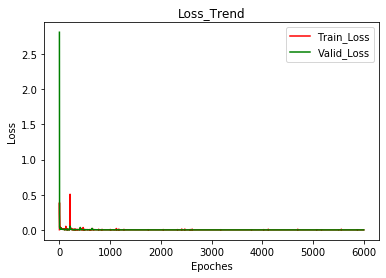

In [6]:
# #print(device)
from time import time
TRAN_TAG = True
if TRAN_TAG:
    if path.exists("model/trajectory_predict_26_4_30.pt"):
        Prednet.load_state_dict(torch.load('model/trajectory_predict_26_4_30.pt'))
    Prednet = Prednet.double()
    Prednet = Prednet.to(device)
    start = time()
    trainIters(Prednet, 1000,0.001,20)
    print('Training time is:',time()-start,'s')

In [109]:
def calcu_XY(predY):
    #input: [batchsize len features]; features:[velx,vely,x,y]
    '''
    deltaY = v0*delta_t + 0.5* a *delta_t^2
    a = (v - v0)/delta_t
    vo
    '''
    vels = predY[:,:,0:2]
    rst_xy = np.zeros(predY[:,:,0:2].shape)
    rst_xy[:,:-predict_length,:] = predY[:,:-predict_length,2:4]
    delta_t = 0.1
   
    for i in range(predict_length):
        a = (vels[:,-(predict_length-i),:] - vels[:,-(predict_length+1-i),:])/delta_t
        delta_xy = vels[:,-(predict_length-i),:]*vels[:,-(predict_length-i),:]-vels[:,-(predict_length+1-i),:]*vels[:,-(predict_length+1-i),:]
        delta_xy = delta_xy/(2*a)
        rst_xy[:,-(predict_length-i),:] = rst_xy[:,-(predict_length+1-i),:] + delta_xy
    return rst_xy

In [110]:
def Eval_net(encoder,optmizer=False):
    n_trajectory_batch = 0
    loss = []
    MSE_pres = []
    MSE_rsts = []
    for local_batch, local_labels in Test:
        n_trajectory_batch = n_trajectory_batch + 1
        criterion = nn.MSELoss()
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        predY = encoder(local_batch)
        #print(WholeSet.std.repeat(BatchSize,100,1).shape)
        test_loss = criterion(predY,local_labels)
        loss.append(test_loss.item())
        std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
        std = std[:,:,:4].to(device)
        mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
        mn = mn[:,:,:4].to(device)
        rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
        rg = rg[:,:,:4].to(device)
        predY = (predY*(rg*std)+mn).detach().cpu()
        pY = np.array(predY )
        #pY =  scipy.signal.savgol_filter(pY, window_length=((x.shape[1]-11)//2)*2+1, polyorder=3,axis=1)
        local_labels = (local_labels*(rg*std)+mn).detach().cpu()
        Y = np.array(local_labels)
        pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
        rst_xy = calcu_XY(pY)
        
        if n_trajectory_batch > 20:
            break
        for i in range(1):
            #plt.figure(i)
            #plt.xlim(0,80)
            #plt.ylim(0,2000)
            #plt.subplot(4,5,n_trajectory_batch)
            #  plt.plot(pY[i,:,2],pY[i,:,3],'r',label='prediction')
            real_predict = torch.from_numpy(Y[:,-predict_length-1:,2:4])
            rst_predict = torch.from_numpy(rst_xy[:,-predict_length-1:,:2])
            pre_predict = torch.from_numpy(pY[:,-predict_length-1:,2:4])
            MSE_pre = criterion(real_predict,pre_predict)
            MSE_rst = criterion(real_predict,rst_predict)
            MSE_pres.append(MSE_pre.item())
            MSE_rsts.append(MSE_rst.item())
            print("MSE pre:",MSE_pre.item())
            print("MSE RST:",MSE_rst.item())
            plt.plot(Y[i,:-predict_length,2],Y[i,:-predict_length,3],'r',label = 'history trajectory')
            if optmizer:
                 plt.plot(rst_xy[i,-predict_length-1:,0],rst_xy[i,-predict_length-1:,1],'b',label=" prediction trajectory via optimizing")
            plt.plot(pY[i,-predict_length-1:,2],pY[i,-predict_length-1:,3],'k',label='prediction trajectory')
            plt.plot(Y[i,-predict_length-1:,2],Y[i,-predict_length-1:,3],'g',label='Real trajectory')
            plt.title('Trajectory prediction')
            plt.xlabel('X ')
            plt.ylabel('Y ')
            plt.legend()
            if optmizer:
                plt.savefig("image/trajectory_output_behavior/trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
            else:
                plt.savefig("image/trajectory_output/trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
        plt.show()
        print('Test loss:',test_loss.item())
    print("mean MSE  pre:",np.mean(MSE_pres))
    print("mean MSE rst:",np.mean(MSE_rsts))
    print('average loss:',np.mean(loss))

MSE pre: 1.1957509049075892
MSE RST: 0.10711063008469685


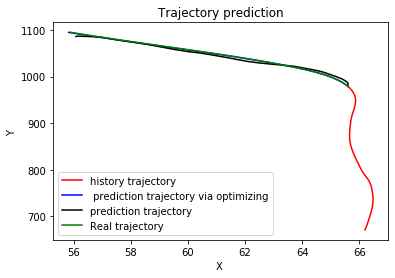

Test loss: 0.001304121205102181
MSE pre: 1.2064617703998968
MSE RST: 0.14698058977769338


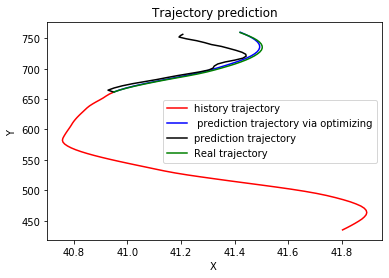

Test loss: 0.0003299456915486333
MSE pre: 1.1360452686490947
MSE RST: 0.07333480818955426


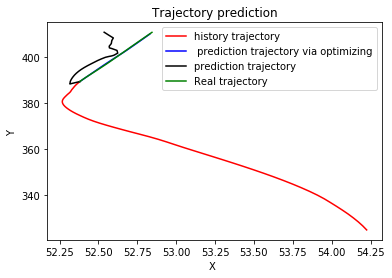

Test loss: 0.00027477533345897283
MSE pre: 1.7672032943507054
MSE RST: 0.18100460385548925


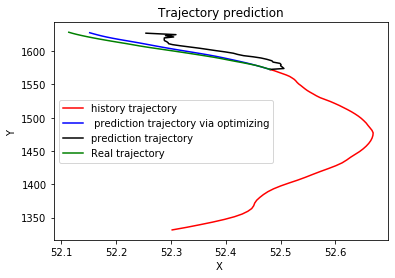

Test loss: 0.0005120428884654248
MSE pre: 1.6909121748140579
MSE RST: 0.14691304825657978


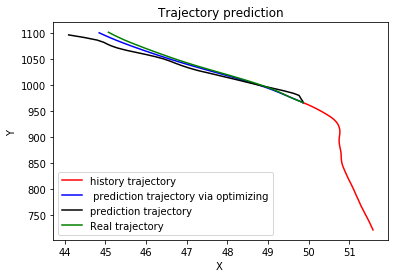

Test loss: 0.0006684522800285722
MSE pre: 1.3539467802385252
MSE RST: 0.05690787145712181


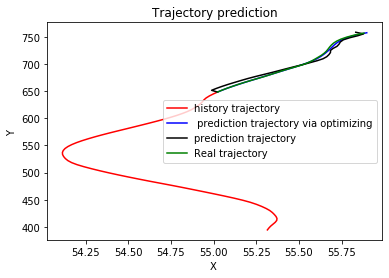

Test loss: 0.0002983814430959243
MSE pre: 1.3600057672293535
MSE RST: 0.1186759180336602


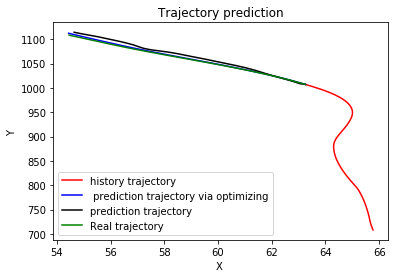

Test loss: 0.00033213616137060256
MSE pre: 1.4391839247203284
MSE RST: 0.11002784542327379


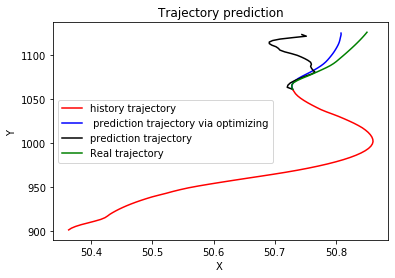

Test loss: 0.0005611726460744355
MSE pre: 1.281559942808704
MSE RST: 0.17835078726197084


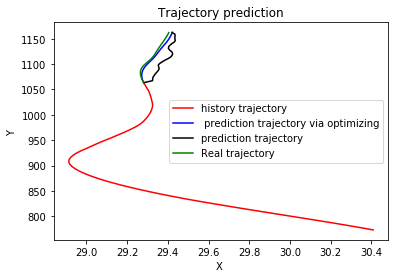

Test loss: 0.0008407966409567949
MSE pre: 1.2628614494379535
MSE RST: 0.0953352260291367


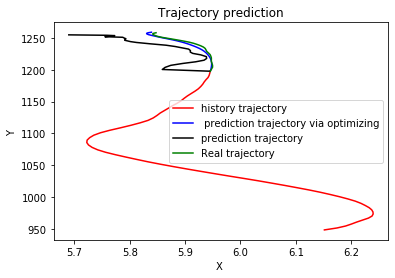

Test loss: 0.00035709025149084465
MSE pre: 1.2962128453696249
MSE RST: 0.2435283620051259


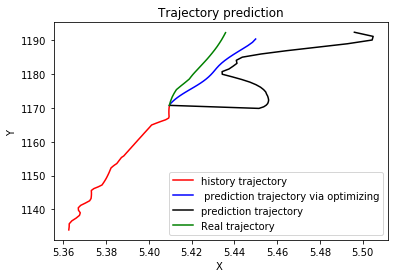

Test loss: 0.00042569586833155523
MSE pre: 1.291281365092899
MSE RST: 0.0863980898755345


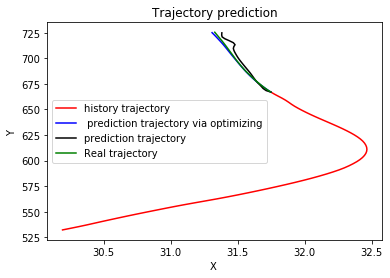

Test loss: 0.00032905959492014953
MSE pre: 1.2315042610422733
MSE RST: 0.07881235868644236


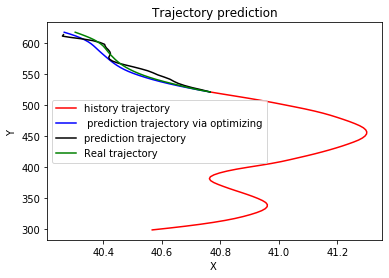

Test loss: 0.0002710948279824211
MSE pre: 1.5511309009089513
MSE RST: 0.09538614524523527


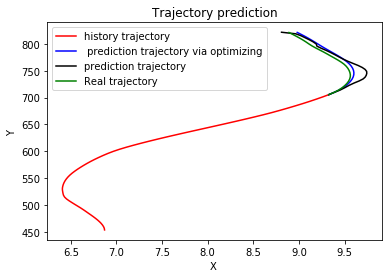

Test loss: 0.00029805226059624596
mean MSE  pre: 1.3617186178549971
mean MSE rst: 0.12276902029867966
average loss: 0.0004859155066730541


In [111]:
hidden_size = 256
Prednet = NNPred(x.shape[2], y.shape[2],hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_26_4_30.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
Eval_net(Prednet,True)

In [112]:
def predict(model,test_load,n,optimizer=False):
    test = iter(test_load)
    x,y =  test.next()
    x,y = x.to(device),y.to(device)
    predY = model(x)
    criterion = nn.MSELoss()
    test_loss = criterion(predY,y)
    std = WholeSet.std.repeat(x.shape[0],x.shape[1],1)
    std = std[:,:,:4].to(device)
    mn = WholeSet.mn.repeat(x.shape[0],x.shape[1],1)
    mn = mn[:,:,:4].to(device)
    rg = WholeSet.range.repeat(x.shape[0],x.shape[1],1)
    rg = rg[:,:,:4].to(device)
    predY = (predY*(rg*std)+mn).detach().cpu()
    pY = np.array(predY)
   # pY =  scipy.signal.savgol_filter(pY, window_length=((x.shape[1]-1)//2)*2+1, polyorder=3,axis=1)
    local_labels = (y*(rg*std)+mn).detach().cpu()
    Y = np.array(local_labels)
    pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
    rst_xy = calcu_XY(pY)
    #rst_xy =  scipy.signal.savgol_filter(rst_xy, window_length=31, polyorder=3,axis=1)
    #rst_xy[:,-30:-1,:]=  scipy.signal.savgol_filter(rst_xy[:,-30:-1,:], window_length=51, polyorder=3,axis=0)
    real_predict = torch.from_numpy(Y[:,-predict_length-1:,2:4])
    rst_predict = torch.from_numpy(rst_xy[:,-predict_length-1:,:2])
    pre_predict = torch.from_numpy(pY[:,-predict_length-1:,2:4])
    MSE_pre = criterion(real_predict,pre_predict)
    MSE_rst = criterion(real_predict,rst_predict)
    print("MSE pre:",MSE_pre.item())
    print("MSE RST:",MSE_rst.item())
    plt.plot(Y[:n,:-predict_length,2][0],Y[:n,:-predict_length,3][0],'r',label = 'history trajectory')
    if optimizer:
        plt.plot(rst_xy[:n,-predict_length-1:,0][0],rst_xy[:n,-predict_length-1:,1][0],'b',label="prediction trajectory via optimizing")
    plt.plot(pY[:n,-predict_length-1:,2][0],pY[:n,-predict_length-1:,3][0],'k',label='prediction trajectory')
    plt.plot(Y[:n,-predict_length-1:,2][0],Y[:n,-predict_length-1:,3][0],'g',label='Real trajectory')
    plt.title('Trajectory prediction')
    plt.xlabel('X ')
    plt.ylabel('Y ')
    plt.legend()
    if optimizer:
        plt.savefig("image/trajectory_output_behavior/trajectory_alone1.svg",dpi = 600)
    else:
        plt.savefig("image/trajectory_output/trajectory_alone.svg",dpi = 600)
    
    print("Test Loss:",test_loss.item())

MSE pre: 0.5933164316879312
MSE RST: 0.036038630807585244
Test Loss: 0.00046014575871084927


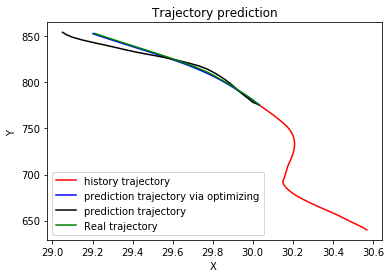

In [94]:
hidden_size = 256
Prednet = NNPred(x.shape[2], y.shape[2],hidden_size, x.shape[0])
Prednet.load_state_dict(torch.load('model/trajectory_predict_26_4_30.pt'))
Prednet = Prednet.double()
Prednet = Prednet.to(device)
Prednet.eval()
predict(Prednet,Test,1,True)

In [113]:
test_iter = iter(Test)
x, y = test_iter.next()
print(x.shape)
x,y = x.to(device),y.to(device)
x = x[0][0].view(-1,len(x[0][0])).unsqueeze(0)
predY = Prednet(x)
print(predY)
print(y[0][30])

torch.Size([128, 100, 26])
tensor([[[ 0.3871,  0.1281,  0.6814, -0.7520]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([ 0.3292,  0.6477,  0.8794, -0.4700], device='cuda:0',
       dtype=torch.float64)


#Let's use the behavior prediction model and the trajectory prediction model to predict the trajectory together.

In [114]:
from behavior_model import LSTM
def compute_label(input_x):
    std = WholeSet.std.repeat(input_x.shape[0],x.shape[1],1)
    std = std.to(device)
    mn = WholeSet.mn.repeat(input_x.shape[0],x.shape[1],1)
    mn = mn.to(device)
    rg = WholeSet.range.repeat(input_x.shape[0],x.shape[1],1)
    rg = rg.to(device)
    print(input_x.shape)
    input_return = (input_x*(rg*std)+mn).detach().cpu()
    #print(mn[0,0,-1],std[0,0,-1],rg[0,0,-1])
    net_behavior = LSTM(1,5,256,2,26) 
    net_behavior.load_state_dict(torch.load('model/behavior_prediction_25.pth'))
    net_behavior.to(device)
    inputs = torch.from_numpy(input_return[:,:,:-1].detach().cpu().numpy().astype(np.float32)).to(device)
    inputs = inputs.view(-1,inputs.shape[2]).unsqueeze(2)
    h = net_behavior.init_hidden(inputs.shape[0])
    h = tuple([each.data for each in h])
    behavior,h = net_behavior(inputs,h)
    _, class_ = torch.max(behavior, dim=1)
    class_ = torch.from_numpy(class_.detach().cpu().numpy().astype(np.double)).to(device)
    class_ = class_.view(input_x.shape[0],x.shape[1],-1)
    y_ = input_return[:,:,-1].view(-1,1).numpy().tolist()
    """"
    y = []
    for i in y_:
        y.append(int(i[0]))
    y = torch.from_numpy(np.array(y)).cuda()
    equal = y.squeeze()== torch.from_numpy(class_.view(-1,1).squeeze().cpu().numpy().astype(np.long)).cuda()
    accu = torch.mean(equal.type(torch.FloatTensor)).item()
    print('accuracy1:',accu)
    """
    std = std[:,:,-1].unsqueeze(2)
    rg = rg[:,:,-1].unsqueeze(2)
    mn = mn[:,:,-1].unsqueeze(2)
    class_ = (class_ -mn) / (std*rg)
    py = torch.cat((input_x[:,:,:-1],class_),2)
    return py

In [115]:
test_iter = iter(Test)
x, y= test_iter.next()
x,y = x.to(device),y.to(device)
print(x[0,0,-1])
print(compute_label(x)[0,0,-1])

tensor(-0.3320, device='cuda:0', dtype=torch.float64)
torch.Size([128, 100, 26])
tensor(-0.3320, device='cuda:0', dtype=torch.float64)


In [135]:
def Eval_net_behavior(encoder,optimization=False):
    n_trajectory_batch = 0
    loss = []
    MSE_pres = []
    MSE_rsts = []
    accuracies = []
    for local_batch, local_labels in Test:
        n_trajectory_batch = n_trajectory_batch + 1
        criterion = nn.MSELoss()
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        
        yl = local_batch[:,:,-1].view(-1,1)
        local_batch = compute_label(local_batch)
        pred = local_batch[:,:,-1].view(-1,1)
        equal = yl.squeeze()==pred.squeeze()
        accu = torch.mean(equal.type(torch.FloatTensor)).item()
        print('Behavior accuracy:',accu)
        accuracies.append(accu)
        predY = encoder(local_batch)
        #print(WholeSet.std.repeat(BatchSize,100,1).shape)
        test_loss = criterion(predY,local_labels)
        loss.append(test_loss.item())
        std = WholeSet.std.repeat(local_batch.shape[0],x.shape[1],1)
        std = std[:,:,:4].to(device)
        mn = WholeSet.mn.repeat(local_batch.shape[0],x.shape[1],1)
        mn = mn[:,:,:4].to(device)
        rg = WholeSet.range.repeat(local_batch.shape[0],x.shape[1],1)
        rg = rg[:,:,:4].to(device)
        predY = (predY*(rg*std)+mn).detach().cpu()
        pY = np.array(predY )
       # pY =  scipy.signal.savgol_filter(pY, window_length=((x.shape[1]-11)//2)*2+1, polyorder=3,axis=1)
        local_labels = (local_labels*(rg*std)+mn).detach().cpu()
        Y = np.array(local_labels)
        pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
        rst_xy = calcu_XY(pY)
        if n_trajectory_batch > 20:
            break
        for i in range(1):
            #plt.figure(i)
            #plt.xlim(0,80)
            #plt.ylim(0,2000)
            #plt.subplot(4,5,n_trajectory_batch)
            #  plt.plot(pY[i,:,2],pY[i,:,3],'r',label='prediction')
            real_predict = torch.from_numpy(Y[:,-predict_length-1:,2:4])
            rst_predict = torch.from_numpy(rst_xy[:,-predict_length-1:,:2])
            pre_predict = torch.from_numpy(pY[:,-predict_length-1:,2:4])
            MSE_pre = criterion(real_predict,pre_predict)
            MSE_rst = criterion(real_predict,rst_predict)
            print("MSE pre:",MSE_pre.item())
            print("MSE RST:",MSE_rst.item())
            MSE_pres.append(MSE_pre)
            MSE_rsts.append(MSE_rst)
            plt.plot(Y[i,:-predict_length,2],Y[i,:-predict_length,3],'r',label = 'history trajectory')
            if optimization:
                plt.plot(rst_xy[i,-predict_length-1:,0],rst_xy[i,-predict_length-1:,1],'b',label=" prediction trajectory via optimizing")
            plt.plot(pY[i,-predict_length-1:,2],pY[i,-predict_length-1:,3],'k',label='prediction trajectory')
            plt.plot(Y[i,-predict_length-1:,2],Y[i,-predict_length-1:,3],'g',label='Real trajectory')
            plt.title('Trajectory prediction')
            plt.xlabel('X ')
            plt.ylabel('Y ')
            plt.legend()
            if optimization:
                plt.savefig("image/trajectory_output_behavior/behavior_trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
            else:
                plt.savefig("image/trajectory_output/behavior_trajectory_{}.svg".format(n_trajectory_batch),dpi=600)
        plt.show()
        print('Test loss:',test_loss.item())
    print("mean MSE  pre:",np.mean(MSE_pres))
    print("mean MSE rst:",np.mean(MSE_rsts))
    print('average loss:',np.mean(loss))
    print("mean behavior accuracy:",np.mean(accuracies))

torch.Size([128, 100, 26])
Behavior accuracy: 0.9990624785423279
MSE pre: 1.3863861642171815
MSE RST: 0.09228890316375225


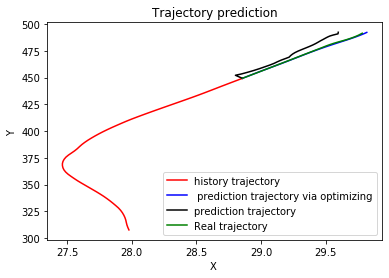

Test loss: 0.0003169775598294289
torch.Size([128, 100, 26])
Behavior accuracy: 0.9987499713897705
MSE pre: 1.1129035278318005
MSE RST: 0.11922641516555815


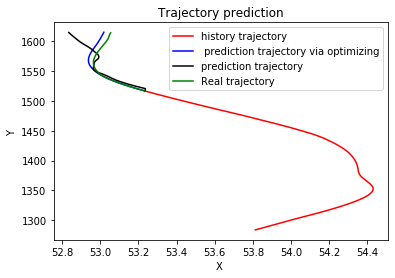

Test loss: 0.0003169634096036138
torch.Size([128, 100, 26])
Behavior accuracy: 0.9992969036102295
MSE pre: 1.4996469856967265
MSE RST: 0.19303775850775323


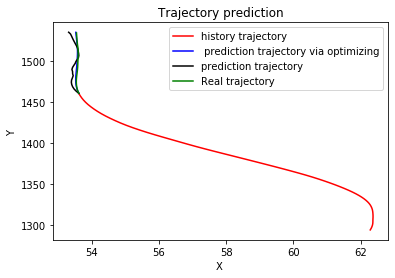

Test loss: 0.0004317539618599589
torch.Size([128, 100, 26])
Behavior accuracy: 0.9989062547683716
MSE pre: 0.9930342643966343
MSE RST: 0.10729214121615173


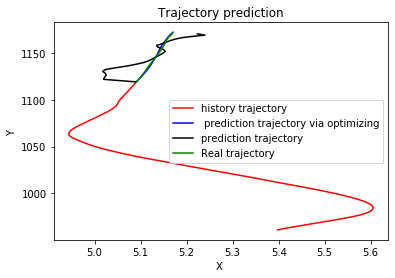

Test loss: 0.00129110953113112
torch.Size([128, 100, 26])
Behavior accuracy: 0.9994531273841858
MSE pre: 1.1084975772811407
MSE RST: 0.08046781877281016


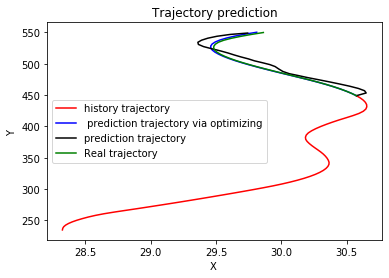

Test loss: 0.00033638152555123314
torch.Size([128, 100, 26])
Behavior accuracy: 0.9996093511581421
MSE pre: 1.335008250459469
MSE RST: 0.08534342240838662


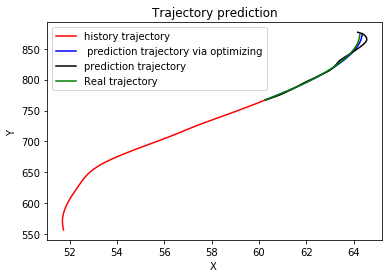

Test loss: 0.0003261514762051125
torch.Size([128, 100, 26])
Behavior accuracy: 0.9990624785423279
MSE pre: 1.4116679218078754
MSE RST: 0.219582943790321


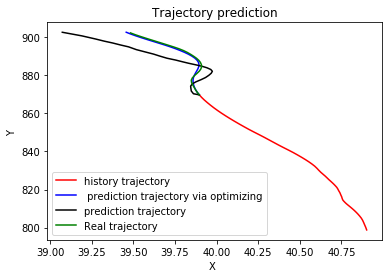

Test loss: 0.0004787664787758694
torch.Size([128, 100, 26])
Behavior accuracy: 0.9991406202316284
MSE pre: 1.8186286403012974
MSE RST: 0.14683208186100494


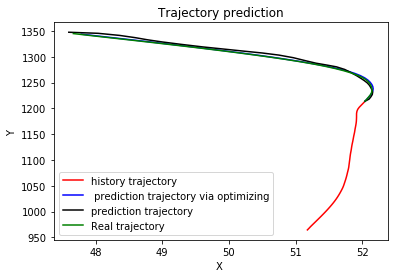

Test loss: 0.00047078874961846705
torch.Size([128, 100, 26])
Behavior accuracy: 0.999218761920929
MSE pre: 1.5569553832360583
MSE RST: 0.0915141804008174


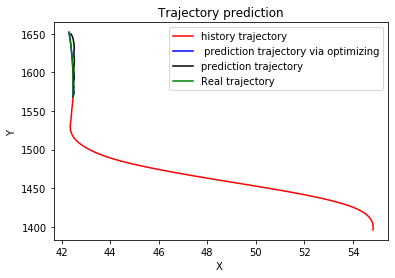

Test loss: 0.0003428520370680145
torch.Size([128, 100, 26])
Behavior accuracy: 0.9986718893051147
MSE pre: 1.419261413101793
MSE RST: 0.09238917415411067


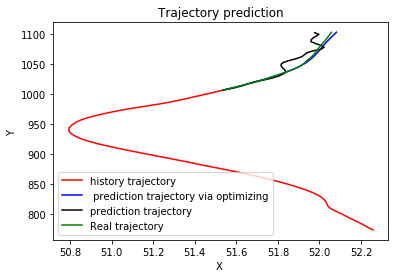

Test loss: 0.0002832188876442522
torch.Size([128, 100, 26])
Behavior accuracy: 0.9989062547683716
MSE pre: 1.197942720621963
MSE RST: 0.08926572231931726


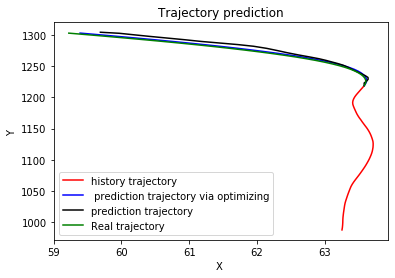

Test loss: 0.00024540063387639143
torch.Size([128, 100, 26])
Behavior accuracy: 0.9992969036102295
MSE pre: 1.3264346436578731
MSE RST: 0.13639043407071524


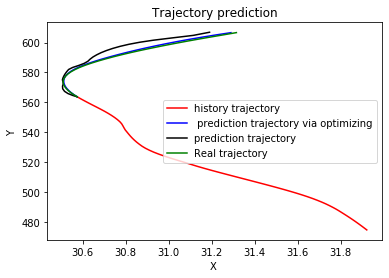

Test loss: 0.0005954501642245656
torch.Size([128, 100, 26])
Behavior accuracy: 0.9989843964576721
MSE pre: 1.3910092503148979
MSE RST: 0.18217677254057058


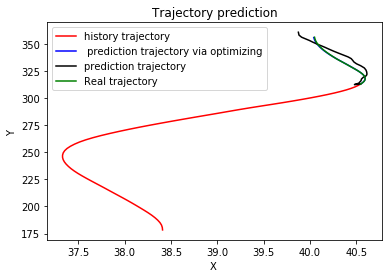

Test loss: 0.000895740372476925
torch.Size([68, 100, 26])
Behavior accuracy: 0.9979411959648132
MSE pre: 1.4861665326658222
MSE RST: 0.10761066174014651


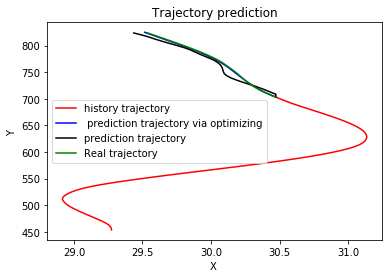

Test loss: 0.0006269570941859001
mean MSE  pre: 1.3602530911136095
mean MSE rst: 0.12452988786510111
average loss: 0.0004970365630036323
mean behavior accuracy: 0.9990214705467224


In [139]:
Eval_net_behavior(Prednet,True)

torch.Size([128, 100, 26])
Behavior accuracy: 0.9990624785423279
MSE pre: 1.0567860959096946
MSE RST: 0.004094865890717747
Test Loss: 0.00030706101816733777


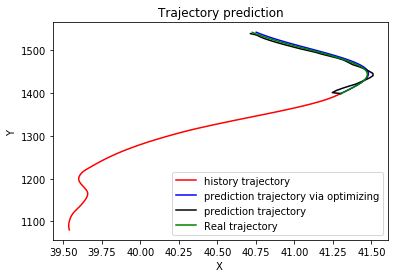

In [134]:
def predict_trajectory_behavior(model,n,optimization=False):
    test = iter(Test)
    x,y =  test.next()
    x,y = x.to(device),y.to(device)
    yl = x[:,:,-1].view(-1,1)
    x = compute_label(x)
    pred = x[:,:,-1].view(-1,1)
    equal = yl.squeeze()==pred.squeeze()
    accu = torch.mean(equal.type(torch.FloatTensor)).item()
    print('Behavior accuracy:',accu)
    
    predY = model(x)
    criterion = nn.MSELoss()
    test_loss = criterion(predY,y)
    std = WholeSet.std.repeat(x.shape[0],x.shape[1],1)
    std = std[:,:,:4].to(device)
    mn = WholeSet.mn.repeat(x.shape[0],x.shape[1],1)
    mn = mn[:,:,:4].to(device)
    rg = WholeSet.range.repeat(x.shape[0],x.shape[1],1)
    rg = rg[:,:,:4].to(device)
    predY = (predY*(rg*std)+mn).detach().cpu()
    pY = np.array(predY)
    #pY =  scipy.signal.savgol_filter(pY, window_length=((x.shape[1]-1)//2)*2+1, polyorder=3,axis=1)
    local_labels = (y*(rg*std)+mn).detach().cpu()
    Y = np.array(local_labels)
    pY[:,:-predict_length,:] = Y[:,:-predict_length,:]
    rst_xy = calcu_XY(pY)
    real_predict = torch.from_numpy(Y[:n,-predict_length-1:,2:4])
    rst_predict = torch.from_numpy(rst_xy[:n,-predict_length-1:,:2])
    pre_predict = torch.from_numpy(pY[:n,-predict_length-1:,2:4])
    MSE_pre = criterion(real_predict,pre_predict)
    MSE_rst = criterion(real_predict,rst_predict)
    print("MSE pre:",MSE_pre.item())
    print("MSE RST:",MSE_rst.item())
   # rst_xy =  scipy.signal.savgol_filter(rst_xy, window_length=31, polyorder=3,axis=1)
   # rst_xy[:,-30:-1,:]=  scipy.signal.savgol_filter(rst_xy[:,-30:-1,:], window_length=51, polyorder=3,axis=0)
    plt.plot(Y[:n,:-predict_length,2][0],Y[:n,:-predict_length,3][0],'r',label = 'history trajectory')
    if optimization:
        plt.plot(rst_xy[:n,-predict_length-1:,0][0],rst_xy[:n,-predict_length-1:,1][0],'b',label="prediction trajectory via optimizing")
    plt.plot(pY[:n,-predict_length-1:,2][0],pY[:n,-predict_length-1:,3][0],'k',label='prediction trajectory')
    plt.plot(Y[:n,-predict_length-1:,2][0],Y[:n,-predict_length-1:,3][0],'g',label='Real trajectory')
    plt.title('Trajectory prediction')
    plt.xlabel('X ')
    plt.ylabel('Y ')
    plt.legend()
    if optimization:
        plt.savefig("image/trajectory_output_behavior/behavior_trajectory_alone1.svg",dpi = 600)
    else:
        plt.savefig("image/trajectory_output/behavior_trajectory_alone.svg",dpi = 600)
    print("Test Loss:",test_loss.item())
    
predict_trajectory_behavior(Prednet,1,True)